**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [104]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [105]:
# Run this cell to start a spark session in this notebook

#start_spark(executor_instances=4, executor_cores=2, worker_memory=1, master_memory=1)
#start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.sql.warehouse.dir,file:/users/home/jzh236/spark-warehouse
spark.ui.port,4341
spark.driver.port,35139
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/jzh236/spark/
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.app.id,app-20231019143834-0190


In [106]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

## Data Processing

### Q1(a) Give an overview of the structure of the datasets, including their sizes, formats, data types, and how each dataset has been stored in HDFS.

In [7]:
!hdfs dfs -ls /data/msd

Found 4 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/genre
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 /data/msd/main
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile


In [18]:
!hdfs dfs -du -h /data/msd

12.3 G   98.1 G   /data/msd/audio
30.1 M   241.0 M  /data/msd/genre
174.4 M  1.4 G    /data/msd/main
490.4 M  3.8 G    /data/msd/tasteprofile


In [19]:
!hdfs dfs -du -s -h /data/msd

12.9 G  103.5 G  /data/msd


In [8]:
!hdfs dfs -ls /data/msd/audio

Found 3 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/attributes
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 /data/msd/audio/statistics


In [9]:
!hdfs dfs -ls /data/msd/audio/attributes

Found 13 items
-rw-r--r--   8 jsw93 supergroup       1051 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        671 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        484 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        898 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup      12317 2021-09-29 10:35 /data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup       9990 2021-09-29 10

In [21]:
!hdfs dfs -cat /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv

Area_Method_of_Moments_Overall_Standard_Deviation_1,real
Area_Method_of_Moments_Overall_Standard_Deviation_2,real
Area_Method_of_Moments_Overall_Standard_Deviation_3,real
Area_Method_of_Moments_Overall_Standard_Deviation_4,real
Area_Method_of_Moments_Overall_Standard_Deviation_5,real
Area_Method_of_Moments_Overall_Standard_Deviation_6,real
Area_Method_of_Moments_Overall_Standard_Deviation_7,real
Area_Method_of_Moments_Overall_Standard_Deviation_8,real
Area_Method_of_Moments_Overall_Standard_Deviation_9,real
Area_Method_of_Moments_Overall_Standard_Deviation_10,real
Area_Method_of_Moments_Overall_Average_1,real
Area_Method_of_Moments_Overall_Average_2,real
Area_Method_of_Moments_Overall_Average_3,real
Area_Method_of_Moments_Overall_Average_4,real
Area_Method_of_Moments_Overall_Average_5,real
Area_Method_of_Moments_Overall_Average_6,real
Area_Method_of_Moments_Overall_Average_7,real
Area_Method_of_Moments_Overall_Average_8,real
Area_Method_of_Moments_Overall_Average_9,real
Area_Method_of_

In [10]:
!hdfs dfs -ls /data/msd/audio/features

Found 13 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:33 /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:33 /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:29 /data/msd/audio/features/msd-mvd-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 20

In [25]:
!hdfs dfs -ls /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv

Found 8 items
-rw-r--r--   8 jsw93 supergroup    8635110 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00000.csv.gz
-rw-r--r--   8 jsw93 supergroup    8636689 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00001.csv.gz
-rw-r--r--   8 jsw93 supergroup    8632696 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00002.csv.gz
-rw-r--r--   8 jsw93 supergroup    8635186 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00003.csv.gz
-rw-r--r--   8 jsw93 supergroup    8635805 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00004.csv.gz
-rw-r--r--   8 jsw93 supergroup    8632126 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00005.csv.gz
-rw-r--r--   8 jsw93 supergroup    8636623 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00006.csv.gz

In [44]:
!hdfs dfs -ls /data/msd/audio/features/msd-tssd-v1.0.csv

Found 8 items
-rw-r--r--   8 jsw93 supergroup  523653885 2021-09-29 10:30 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00000.csv.gz
-rw-r--r--   8 jsw93 supergroup  523973513 2021-09-29 10:31 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00001.csv.gz
-rw-r--r--   8 jsw93 supergroup  523846402 2021-09-29 10:29 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00002.csv.gz
-rw-r--r--   8 jsw93 supergroup  523674195 2021-09-29 10:29 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00003.csv.gz
-rw-r--r--   8 jsw93 supergroup  523778813 2021-09-29 10:30 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00004.csv.gz
-rw-r--r--   8 jsw93 supergroup  524004691 2021-09-29 10:30 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00005.csv.gz
-rw-r--r--   8 jsw93 supergroup  523959080 2021-09-29 10:30 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00006.csv.gz
-rw-r--r--   8 jsw93 supergroup  499578908 2021-09-29 10:29 /data/msd/audio/features/msd-tssd-v1.0.csv/part-00007.csv.gz


In [11]:
!hdfs dfs -ls /data/msd/audio/statistics

Found 1 items
-rw-r--r--   8 jsw93 supergroup   42224669 2021-09-29 10:28 /data/msd/audio/statistics/sample_properties.csv.gz


In [12]:
!hdfs dfs -ls /data/msd/genre

Found 3 items
-rw-r--r--   8 jsw93 supergroup   11625230 2021-09-29 10:35 /data/msd/genre/msd-MAGD-genreAssignment.tsv
-rw-r--r--   8 jsw93 supergroup    8820054 2021-09-29 10:35 /data/msd/genre/msd-MASD-styleAssignment.tsv
-rw-r--r--   8 jsw93 supergroup   11140605 2021-09-29 10:35 /data/msd/genre/msd-topMAGD-genreAssignment.tsv


In [13]:
!hdfs dfs -ls /data/msd/main

Found 1 items
drwxr-xr-x   - jsw93 supergroup          0 2022-05-23 12:11 /data/msd/main/summary


In [15]:
!hdfs dfs -ls /data/msd/main/summary

Found 2 items
-rw-r--r--   8 jsw93 supergroup   58658141 2021-09-29 10:28 /data/msd/main/summary/analysis.csv.gz
-rw-r--r--   8 jsw93 supergroup  124211304 2021-09-29 10:28 /data/msd/main/summary/metadata.csv.gz


In [14]:
!hdfs dfs -ls /data/msd/tasteprofile

Found 2 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile/mismatches
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv


In [16]:
!hdfs dfs -ls /data/msd/tasteprofile/mismatches

Found 2 items
-rw-r--r--   8 jsw93 supergroup      91342 2021-09-29 10:35 /data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt
-rw-r--r--   8 jsw93 supergroup    2026182 2021-09-29 10:35 /data/msd/tasteprofile/mismatches/sid_mismatches.txt


In [80]:
!hdfs dfs -cat /data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt

9d8
< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF2> Josipa Lisac  -  razloga  !=  Lisac Josipa  -  1000 razloga
19d17
< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5ED> Lutan Fyah  -  Nuh Matter the Crisis Feat. Midnite  !=  Midnite  -  Nah Matter the Crisis
29d26
< ERROR: <SOASCRF12A8C1372E6 TRMHIPJ128F426A2E2> Gaetano Donizetti  -  L'Elisir d'Amore: Act Two: Come sen va contento!  !=  Gianandrea Gavazzeni_ Orchestra E Coro Del Maggio Musicale Fiorentino_ Carlo Bergonzi_ Renata Scotto  -  L'Elisir D'Amore_ Act 2: Come Sen Va Contento (Adina) (Donizetti)
33d29
< ERROR: <SOITDUN12A58A7AACA TRMHXGK128F42446AB> C.J. Chenier  -  Ay, Ai Ai  !=  Clifton Chenier  -  Ay_ Ai Ai
52d47
< ERROR: <SOLZXUM12AB018BE39 TRMRSOF12903CCF516> 許志安  -  男人最痛  !=  Andy Hui  -  Nan Ren Zui Tong
126d120
< ERROR: <SOTJTDT12A8C13A8A6 TRMNKQE128F427C4D8> S  -  h  !=  Sammy Hagar  -  20th Century Man (Live)
153d146
< ERROR: <SOGCVWB12AB0184CE2 TRMUNCZ128F932A95D> H  -  Y  !=  Hawkwind  -  25 Years (Alternate Mix)
23

In [96]:
!hdfs dfs -cat /data/msd/tasteprofile/mismatches/sid_mismatches.txt

ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground
ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It
ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (BONUS TRACK)
ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0> Death in Vegas  -  Anita Berber  !=  Valen Hsu  -  Shi Yi
ERROR: <SONGXCA12A8C13E82E TRMMAYZ128F429ECE6> Grupo Exterminador  -  El Triunfador  !=  I Ribelli  -  Lei M'Ama
ERROR: <SOMBCRC12A67ADA435 TRMMNVU128EF343EED> Fading Friend  -  Get us out!  !=  Masterboy  -  Feel The Heat 2000
ERROR: <SOTDWDK12A8C13617B TRMMNCZ128F426FF0E> Daevid Allen  -  Past Lives  !=  Bhimsen Joshi  -  Raga - Shuddha Sarang_ Aalap
ERROR: <SOEBURP12AB018C2FB TRMMPBS12903CE90E1> Cristian Paduraru  -  Born Again  !=  Yespiring  -  Journey Stages
ERROR: <SOSRJHS12A

ERROR: <SOCCGNS12AAF3B588E TRCAQZC128F9304534> Termplex  -  Sense Of Beauty  !=  The Human League  -  Don't You Want Me (Special Extended Dance Mix)
ERROR: <SOMQYBR12AC468CFDE TRCAZTM12903D04290> Luke Vibert  -   E-Z Listener  !=  Lao Che  -  Czarne Kowboje
ERROR: <SOCDNFW12AB01900BE TRCAAKN12903CEC51D> Craving  -  Never Alone  !=  Mercyful Fate  -  Egypt
ERROR: <SODBNQS12A6D4F71EA TRCNMSU128F14770CA> Visage  -  The Steps  !=  Rush  -  2112 [Rio Live Album Version]
ERROR: <SOYCIEH12AB0183C0B TRCNGIW12903CB1C99> DJ Drama  -  I Love Her  !=  Bjoern Stolpmann  -  Wild Child
ERROR: <SONCGQL12A58A7B45C TRCNHRB12903CA0B66> Eliza Carthy  -  Cumberland Waltz / Petit Homme / Miss Bowls'  !=  Oscar Woods  -  Step Dance Tune
ERROR: <SOIAPAJ12A6D4FA593 TRCNQUR128F1498675> Daisy May  -  We Are  !=  João Gilberto / Gilberto Gil / Caetano Veloso  -  Aquarela Do Brasil
ERROR: <SODIENO12A8C1413FE TRCNAPJ128F92F44D1> DJ ReMix Factory  -  Rain Over Me (Remix)  !=  Diskoteka Avariya  -  Pochemu lubov uhod

ERROR: <SOPGPNC12AC4687536 TRDQZKE12903CED688> Dubee  -  Get Down (feat. Sleep Dank & Da Undadogg)  !=  Da 'Unda' Dogg  -  The Get Down (feat. Sleep Dank & Dubee)
ERROR: <SOOAMWV12A8C135C69 TRDQOJU128F42634CB> Watermark  -  Peace  !=  As One  -  You Live
ERROR: <SOHVXYN12A8AE46D71 TRDQXXK128F422C191> Yves Larock  -  Speed Up [Deliquent Remix]  !=  Taio Cruz  -  I Can Be
ERROR: <SOLHQIC12A8C136590 TRDQKQQ128F4244DE9> B-Real  -  Hold You Down  !=  T.I. & DJ Drama  -  100 Yards
ERROR: <SOXWFDA12AB0188071 TRDZWDJ12903C976AD> King  -  The Flying Crow  !=  Cripple Clarence Lofton  -  Had A Dream
ERROR: <SOHMVZW12AB01903B1 TRDZWMM12903CE6DC6> Ryan Scane  -  Roads Less Traveled  !=  Luigi Masi  -  Radar (LoveRush UK! Club Remix)
ERROR: <SOZBQHE12A6D4F8C3D TRDZGBO128F147D9BE> Roger Clyne & The Peacemakers  -  Play On  !=  Ataxia  -  Montreal (Album Version)
ERROR: <SORLHYP12A6701E908 TRDZGAN128E078826C> Howard Carpendale  -  Es War Nichts Los Heut Nacht  !=  Flea  -  Sono Un Pesce
ERROR: <SOQBH

ERROR: <SOWXPGR12A58A7AFE1 TRRDLIT12903D0CD5F>   -    !=  Wu-Tang Clan  -  Wu-Tang: 7th Chamber
ERROR: <SOWCQMG12A6D4FC6C4 TRRDEBU128F42484A9>   -    !=  Every Time I Die  -  Tusk And Temper
ERROR: <SORYXEI12D021B5899 TRRDEWZ128F92E1161>   -    !=  Apocalyptica / Manu  -  En Vie
ERROR: <SOZITXB12D02190961 TRRDVYZ128F1453606>   -    !=  Melanie Brown  -  SWEET PLEASURE
ERROR: <SOXAKXH12A8C142E82 TRRDVHQ128F92E4F80>   -    !=  Cheap Trick  -  Decaf
ERROR: <SOLMBRO1288D3E50DD TRRDDDE128F422C0CC>   -    !=  Lil Wayne  -  Cash Money Millionaires
ERROR: <SOYQZRH12D021B2209 TRROWJW128F42BC1A1>   -    !=  John Denver  -  Like A Sad Song
ERROR: <SOHSLEO12D0219A71D TRROWJT12903CC3A43>   -    !=  Gyroscope  -  S4
ERROR: <SOKRTCV12A8C13A0D7 TRROGBC128F42904E1>   -    !=  Cesaria Evora  -  Amor Di Mundo
ERROR: <SOBKUCY12D02193A4F TRROHKM128E0791E6B>   -    !=  Rufus Wainwright  -  Grey Gardens
ERROR: <SOFVONU12A58A7D186 TRROHYG128F42894D5>   -    !=  Glenn Miller & His Orchestra;Skip Nelson;The Mod

ERROR: <SOGNDFT12AB0182876 TRTHXZA128F92DFEE6>   -    !=  Björk  -  Big Time Sensuality (Morales Def Radio Mix)
ERROR: <SODXJFV12A8C135596 TRTHXIZ128F42554CA>   -    !=  Aretha Franklin  -  Do You Know (Hey Now Hey (The Other Side Of The Sky Outtake)
ERROR: <SOBNIQG12A6D4F7907 TRTHKCI128F14892CC>   -    !=  Blondie  -  Call Me (Spanish Version) (2004 Digital Remaster)
ERROR: <SOKHYCA12AB018D078 TRTCWHU12903CCE492>   -    !=  Morcheeba  -  In The Hands Of The Gods (Featuring Biz Markie)
ERROR: <SOSZOBG12A8C13D7AB TRTCCZX128F42ADE87>   -    !=  Billy Ocean  -  What You Doing To Me
ERROR: <SOSIYNA12D02199835 TRTCRBA128F92D30FE>   -    !=  Sarah McLachlan  -  Witness
ERROR: <SOSXXDO12A58A7889D TRTCBYJ128F425EE15>   -    !=  The Fray  -  Look After You
ERROR: <SOBSANT12AB017F363 TRTCQSQ128F9305F00>   -    !=  Placebo  -  Kitty Litter
ERROR: <SONJGFF12A8C13E457 TRTCAXI128F9361359>   -    !=  Joe Bonamassa  -  Torn Down
ERROR: <SOOOHNU12D02190336 TRTCURA12903CE6B0F>   -    !=  Insane Clown Po

ERROR: <SOGCVBI12A8C134F2E TROSHWT128F4246843>   -    !=  Young Jeezy and Fabolous  -  Smack
ERROR: <SONYXKE12D021B4974 TROSRJV128F423FC30>   -    !=  Vitamin String Quartet  -  All That I've Got
ERROR: <SOPHUUG12AAF3B5164 TROSRUP128F92D6A01>   -    !=  Dr. Dre ft. The Arabian & Sheiks  -  Innovative Life
ERROR: <SOZMKHW12A8C13F37F TROSILF128F92E22C9>   -    !=  Roxy Music  -  In Every Dream Home A Heartache
ERROR: <SOCEXGR12A8C1357F3 TROSASR128F425F20A>   -    !=  The Ventures  -  Tsunami
ERROR: <SOMNMJO12A8C1335F4 TROSNNI128F426E913>   -    !=  Robert Johnson  -  Come On In My Kitchen
ERROR: <SOAZGSB12AF72ABA39 TROSTYP128F93353EF>   -    !=  Diana Ross & The Supremes  -  I'm Livin' In Shame
ERROR: <SOIQPFU12AAF3B1E32 TROSTSF128F9303087>   -    !=  Jackie Wilson  -  Reet Petite
ERROR: <SONDCZH12B0B807AFB TROSTPK128F423F039>   -    !=  Pixies  -  U-mass
ERROR: <SODJFCW12AB018C52F TROSEBD12903CB59C0>   -    !=  Blind Lemon Jefferson  -  Chock House Blues
ERROR: <SOLMJLL12A67FFB32B TROSJ

In [17]:
!hdfs dfs -ls /data/msd/tasteprofile/triplets.tsv

Found 8 items
-rw-r--r--   8 jsw93 supergroup   64020759 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00000.tsv.gz
-rw-r--r--   8 jsw93 supergroup   64038083 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00001.tsv.gz
-rw-r--r--   8 jsw93 supergroup   64077499 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00002.tsv.gz
-rw-r--r--   8 jsw93 supergroup   64102442 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00003.tsv.gz
-rw-r--r--   8 jsw93 supergroup   63998697 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00004.tsv.gz
-rw-r--r--   8 jsw93 supergroup   64049032 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00005.tsv.gz
-rw-r--r--   8 jsw93 supergroup   64064101 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00006.tsv.gz
-rw-r--r--   8 jsw93 supergroup   63788582 2021-09-29 10:35 /data/msd/tasteprofile/triplets.tsv/part-00007.tsv.gz


### Q1(b) Count the number of rows in each of the datasets. How do the counts compare to the total number of unique songs?

In [47]:
!hdfs dfs -cat /data/msd/audio/attributes/*.csv | wc -l

3929


In [1]:
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-mvd-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-rh-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-rp-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-ssd-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-trh-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l
!hdfs dfs -cat /data/msd/audio/features/msd-tssd-v1.0.csv/part-*.csv.gz | gzip -d -c| wc -l


994623
994623
994623
994623
994623
994623
995001
994188
994188
994188
994188
994188
994188


In [48]:
!hdfs dfs -cat /data/msd/audio/statistics/sample_properties.csv.gz | gzip -d -c | wc -l

992866


In [3]:
!hdfs dfs -cat /data/msd/genre/* | wc -l

1103077


In [5]:
!hdfs dfs -cat /data/msd/main/summary/* | gzip -d -c| wc -l

2000002


In [6]:
!hdfs dfs -cat /data/msd/tasteprofile/mismatches/* | wc -l

20032


In [8]:
!hdfs dfs -cat /data/msd/tasteprofile/triplets.tsv/part-*.tsv.gz | gzip -d -c| wc -l

48373586


### Q2(a) Some of the tracks in the Million Song Dataset were matched to the wrong songs in the Taste Profile dataset and there is a list of song-track mismatches that were automatically identified and a list of mismatches that were manually accepted. Do we need to take any action to account for this based on the datasets that we are using in the sections below and how we are using them?

In [107]:
# Load sid_matches_manually_accepted.txt into a DataFrame
matches_manual = (
        spark.read.format('text')
        .option("header", "false")
        .option("inferSchema", "false")
        .load("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
        )

# Load sid_mismatches.txt into a DataFrame
mismatches_automatic = (
        spark.read.format('text')
        .option("header", "false")
        .option("inferSchema", "false")
        .load("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
        )


In [108]:
print(matches_manual.count())
show_as_html(matches_manual)

938


,value
0,9d8
1,< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF...
2,19d17
3,< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5E...
4,29d26
5,< ERROR: <SOASCRF12A8C1372E6 TRMHIPJ128F426A2E...
6,33d29
7,< ERROR: <SOITDUN12A58A7AACA TRMHXGK128F42446A...
8,52d47
9,< ERROR: <SOLZXUM12AB018BE39 TRMRSOF12903CCF51...


In [109]:
# Define the regular expression pattern
pattern = "<([^>]+) ([^>]+)>"

# Use regexp_extract to extract the desired part into a new column
matches_manual_new = matches_manual \
        .withColumn("Song_ID", F.regexp_extract(F.col("value"), pattern, 1)) \
        .withColumn("Track_ID", F.regexp_extract(F.col("value"), pattern, 2))

# Remove the "< ERROR: " part from the "Song_ID" column
matches_manual_new = matches_manual_new \
        .withColumn("Song_ID", F.regexp_replace(F.col("Song_ID"), "ERROR: <", ""))

show_as_html(matches_manual_new)

,value,Song_ID,Track_ID
0,9d8,,
1,< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF...,SOFQHZM12A8C142342,TRMWMFG128F92FFEF2
2,19d17,,
3,< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5E...,SODXUTF12AB018A3DA,TRMWPCD12903CCE5ED
4,29d26,,
5,< ERROR: <SOASCRF12A8C1372E6 TRMHIPJ128F426A2E...,SOASCRF12A8C1372E6,TRMHIPJ128F426A2E2
6,33d29,,
7,< ERROR: <SOITDUN12A58A7AACA TRMHXGK128F42446A...,SOITDUN12A58A7AACA,TRMHXGK128F42446AB
8,52d47,,
9,< ERROR: <SOLZXUM12AB018BE39 TRMRSOF12903CCF51...,SOLZXUM12AB018BE39,TRMRSOF12903CCF516


In [110]:
print(mismatches_automatic.count())
show_as_html(mismatches_automatic)

19094


,value
0,ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10>...
1,ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1>...
2,ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E>...
3,ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0>...
4,ERROR: <SONGXCA12A8C13E82E TRMMAYZ128F429ECE6>...
5,ERROR: <SOMBCRC12A67ADA435 TRMMNVU128EF343EED>...
6,ERROR: <SOTDWDK12A8C13617B TRMMNCZ128F426FF0E>...
7,ERROR: <SOEBURP12AB018C2FB TRMMPBS12903CE90E1>...
8,ERROR: <SOSRJHS12A6D4FDAA3 TRMWMEL128F421DA68>...
9,ERROR: <SOIYAAQ12A6D4F954A TRMWHRI128F147EA8E>...


In [111]:
# Define the regular expression pattern
pattern = "<([^>]+) ([^>]+)>"

# Use regexp_extract to extract the desired part into a new column
mismatches_automatic_new = mismatches_automatic \
        .withColumn("Song_ID", F.regexp_extract(F.col("value"), pattern, 1)) \
        .withColumn("Track_ID", F.regexp_extract(F.col("value"), pattern, 2))

show_as_html(mismatches_automatic_new)

,value,Song_ID,Track_ID
0,ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10>...,SOUMNSI12AB0182807,TRMMGKQ128F9325E10
1,ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1>...,SOCMRBE12AB018C546,TRMMREB12903CEB1B1
2,ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E>...,SOLPHZY12AC468ABA8,TRMMBOC12903CEB46E
3,ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0>...,SONGHTM12A8C1374EF,TRMMITP128F425D8D0
4,ERROR: <SONGXCA12A8C13E82E TRMMAYZ128F429ECE6>...,SONGXCA12A8C13E82E,TRMMAYZ128F429ECE6
5,ERROR: <SOMBCRC12A67ADA435 TRMMNVU128EF343EED>...,SOMBCRC12A67ADA435,TRMMNVU128EF343EED
6,ERROR: <SOTDWDK12A8C13617B TRMMNCZ128F426FF0E>...,SOTDWDK12A8C13617B,TRMMNCZ128F426FF0E
7,ERROR: <SOEBURP12AB018C2FB TRMMPBS12903CE90E1>...,SOEBURP12AB018C2FB,TRMMPBS12903CE90E1
8,ERROR: <SOSRJHS12A6D4FDAA3 TRMWMEL128F421DA68>...,SOSRJHS12A6D4FDAA3,TRMWMEL128F421DA68
9,ERROR: <SOIYAAQ12A6D4F954A TRMWHRI128F147EA8E>...,SOIYAAQ12A6D4F954A,TRMWHRI128F147EA8E


In [112]:
df = matches_manual_new.join(mismatches_automatic_new,mismatches_automatic_new.Track_ID == matches_manual_new.Track_ID,"inner")
show_as_html(df)

,value,Song_ID,Track_ID,value,Song_ID,Track_ID
0,> ERROR: <SOQHWJX12A8C143938 TRSASIF128F931BCB...,SOQHWJX12A8C143938,TRSASIF128F931BCB4,ERROR: <SOQHWJX12A8C143938 TRSASIF128F931BCB4>...,SOQHWJX12A8C143938,TRSASIF128F931BCB4
1,< ERROR: <SOQHWJX12A8C143938 TRSASIF128F931BCB...,SOQHWJX12A8C143938,TRSASIF128F931BCB4,ERROR: <SOQHWJX12A8C143938 TRSASIF128F931BCB4>...,SOQHWJX12A8C143938,TRSASIF128F931BCB4


In [113]:
mismatch_df = mismatches_automatic_new.join(matches_manual_new,mismatches_automatic_new.Track_ID == matches_manual_new.Track_ID,"leftanti")
mismatch_df.count()

19093

In [114]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


In [115]:
#load triplets into spark
schema = StructType([
        StructField("User", StringType(), True),
        StructField("Song", StringType(), True),
        StructField("PlayCount", DoubleType(), True)
        ])
taste_triplets = (
        spark.read.format("csv")
        .option("inferSchema", "true")
        .option("header", "false")
        .option("delimiter", "\t")
        .schema(schema)
        .load("hdfs:///data/msd/tasteprofile/triplets.tsv")
        .repartition(partitions)
        )
print(taste_triplets.count())
taste_triplets.printSchema()
show_as_html(taste_triplets)

48373586
root
 |-- User: string (nullable = true)
 |-- Song: string (nullable = true)
 |-- PlayCount: double (nullable = true)



,User,Song,PlayCount
0,8a3a03659b96bd3b780c681e80be99d214466747,SOCWQYO12A58A79FE8,1.0
1,c41d4f258f4e5111819419f10bd2b05f7c0dc9b0,SOBXCVN12A58A7699E,1.0
2,0620b18aebb25509cdb2eb86c61e67a0319ea3ca,SOKCJPR12AF72AC24D,2.0
3,1c782acd2d057879d630031372cb5b53d3dadaa7,SOXDPEP12AB0180E1E,2.0
4,3a8846fb6a1d0dc0a34e5bc9cdffdcaeedfea0c7,SOUAGMI12A8C1382C2,1.0
5,6136ba5d840a5cde7074703eeb0b690183d9a668,SOFVZOQ12AB018146B,1.0
6,5261a9f047d0336c9e45d959f313878716547a06,SOGXOAP12AB0189474,3.0
7,5310f9840ab55749ce3c5a0542c4f594aaa61667,SOCVTLJ12A6310F0FD,1.0
8,c7165676b06c810ecd5ab534e1ce0bb987b54f49,SOEHLCH12A8C141321,1.0
9,e3a19367a25e3689f60af124ee6feb595c7496aa,SOHAVKZ12AF72A05C3,2.0


In [116]:
taste_triplets_new = taste_triplets.join(mismatch_df,taste_triplets.Song == mismatch_df.Song_ID,"leftanti")
taste_triplets_new.count()

45795111

### Q2(b) Load the audio feature attribute names and types from the audio/attributes directory and think about how they can be used to define schemas for the audio feature datasets themselves. Note that the attribute files and feature datasets share the same prefix and that the attribute types are named consistently. Think about how you can automate the creation of StructType by mapping attribute types to pyspark.sql.types objects.

In [10]:
!hdfs dfs -ls /data/msd/audio/attributes

Found 13 items
-rw-r--r--   8 jsw93 supergroup       1051 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        671 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        484 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        898 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup      12317 2021-09-29 10:35 /data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup       9990 2021-09-29 10

In [11]:
!hdfs dfs -cat /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv


Area_Method_of_Moments_Overall_Standard_Deviation_1,real
Area_Method_of_Moments_Overall_Standard_Deviation_2,real
Area_Method_of_Moments_Overall_Standard_Deviation_3,real
Area_Method_of_Moments_Overall_Standard_Deviation_4,real
Area_Method_of_Moments_Overall_Standard_Deviation_5,real
Area_Method_of_Moments_Overall_Standard_Deviation_6,real
Area_Method_of_Moments_Overall_Standard_Deviation_7,real
Area_Method_of_Moments_Overall_Standard_Deviation_8,real
Area_Method_of_Moments_Overall_Standard_Deviation_9,real
Area_Method_of_Moments_Overall_Standard_Deviation_10,real
Area_Method_of_Moments_Overall_Average_1,real
Area_Method_of_Moments_Overall_Average_2,real
Area_Method_of_Moments_Overall_Average_3,real
Area_Method_of_Moments_Overall_Average_4,real
Area_Method_of_Moments_Overall_Average_5,real
Area_Method_of_Moments_Overall_Average_6,real
Area_Method_of_Moments_Overall_Average_7,real
Area_Method_of_Moments_Overall_Average_8,real
Area_Method_of_Moments_Overall_Average_9,real
Area_Method_of_

In [12]:
!hdfs dfs -cat /data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv

"component_1",NUMERIC
"component_2",NUMERIC
"component_3",NUMERIC
"component_4",NUMERIC
"component_5",NUMERIC
"component_6",NUMERIC
"component_7",NUMERIC
"component_8",NUMERIC
"component_9",NUMERIC
"component_10",NUMERIC
"component_11",NUMERIC
"component_12",NUMERIC
"component_13",NUMERIC
"component_14",NUMERIC
"component_15",NUMERIC
"component_16",NUMERIC
"component_17",NUMERIC
"component_18",NUMERIC
"component_19",NUMERIC
"component_20",NUMERIC
"component_21",NUMERIC
"component_22",NUMERIC
"component_23",NUMERIC
"component_24",NUMERIC
"component_25",NUMERIC
"component_26",NUMERIC
"component_27",NUMERIC
"component_28",NUMERIC
"component_29",NUMERIC
"component_30",NUMERIC
"component_31",NUMERIC
"component_32",NUMERIC
"component_33",NUMERIC
"component_34",NUMERIC
"component_35",NUMERIC
"component_36",NUMERIC
"component_37",NUMERIC
"component_38",NUMERIC
"component_39",NUMERIC
"component_40",NUMERIC
"component_41",NUMERIC
"component_42",NUMERIC
"component_43",NUMERIC
"component_44",NUMER

In [9]:
!hdfs dfs -ls /data/msd/audio/features

Found 13 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:31 /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:33 /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:33 /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:29 /data/msd/audio/features/msd-mvd-v1.0.csv
drwxr-xr-x   - jsw93 supergroup          0 20

In [36]:
# Define the HDFS directory path containing attribute files
attributes_dir = "/data/msd/audio/attributes/"

# List all the attribute files in the directory
attribute_files = spark.sparkContext.wholeTextFiles(attributes_dir + "*.csv").keys().collect()

# Print the list of attribute files
for attribute_file in attribute_files:
    print(attribute_file)

hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-rh-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-rp-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-tssd-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
hdfs://masternode2:9000/data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
hdfs://masternode2:

In [51]:
# Define an empty set to store attribute types
attribute_types_set = set()

# Iterate through each attribute file and extract attribute types
for attribute_file in attribute_files:
    # Read the attribute file content
    attribute_content = spark.read.option("header", "false").csv(attribute_file)

    # Extract attribute types and add them to the set
    for row in attribute_content.collect():
        attribute_type = row[1]
        attribute_types_set.add(attribute_type)

# Convert the set to a list to remove duplicates
attribute_types_list = list(attribute_types_set)

# Print the attribute types list
print("Attribute Types:")
print(attribute_types_list)

Attribute Types:
['NUMERIC', 'string', 'real', 'STRING']


In [31]:
prefix = "msd-jmir-area-of-moments-all-v1.0"
attribute_files = spark.sparkContext.wholeTextFiles("hdfs:///data/msd/audio/attributes/" + prefix + ".attributes" +"*.csv").keys().collect()

attributes_df = spark.read.csv(attribute_files, header=False, inferSchema=False)
attributes_df.show()

+--------------------+----+
|                 _c0| _c1|
+--------------------+----+
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
|Area_Method_of_Mo...|real|
+--------------------+----+
only showing top 20 rows



In [92]:
def create_schemas_from_directory(prefix):
    
    spark = SparkSession.builder.appName("AttributeLoader").getOrCreate()
    
    # List all the attribute files in the directory
    attribute_files = spark.sparkContext.wholeTextFiles("hdfs:///data/msd/audio/attributes/" + prefix + ".attributes" +"*.csv").keys().collect()
    
    # Load the CSV file into a DataFrame
    attributes_df = spark.read.csv(attribute_files, header=False, inferSchema=False)
    
    # Define the schema using StructType
    schema = StructType()

    for row in attributes_df.rdd.collect():
        attribute_name = row["_c0"]
        attribute_type = row["_c1"].lower()

        # Map attribute types to PySpark types
        type_mapping = {
        "string": StringType(),
        "real": DoubleType(),
        "numeric": DoubleType()
        }

        if attribute_type in type_mapping:
            field = StructField(attribute_name, type_mapping[attribute_type], True)
            schema.add(field)

    return schema

prefix =  "msd-jmir-area-of-moments-all-v1.0"
schema = create_schemas_from_directory(prefix)
schema

StructType(List(StructField(Area_Method_of_Moments_Overall_Standard_Deviation_1,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_2,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_3,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_4,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_5,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_6,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_7,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_8,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_9,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Standard_Deviation_10,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Average_1,DoubleType,true),StructField(Area_Method_of_Moments_Overall_Average_2,DoubleType,true),StructField(Area_Method_of_Moment

## Audio similarity

### Q1(a) Produce descriptive statistics for each feature column in the dataset you picked. Are any features strongly correlated?

In [47]:
!hdfs dfs -du -h /data/msd/audio/features

65.5 M   524.2 M  /data/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
53.1 M   424.6 M  /data/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
35.8 M   286.5 M  /data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
70.8 M   566.1 M  /data/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
51.1 M   408.9 M  /data/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
412.2 M  3.2 G    /data/msd/audio/features/msd-marsyas-timbral-v1.0.csv
1.3 G    10.3 G   /data/msd/audio/features/msd-mvd-v1.0.csv
240.3 M  1.9 G    /data/msd/audio/features/msd-rh-v1.0.csv
4.0 G    32.3 G   /data/msd/audio/features/msd-rp-v1.0.csv
640.6 M  5.0 G    /data/msd/audio/features/msd-ssd-v1.0.csv
1.4 G    11.5 G   /data/msd/audio/features/msd-trh-v1.0.csv
3.9 G    31.0 G   /data/msd/audio/features/msd-tssd-v1.0.csv


In [117]:
# Other imports to be used locally

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib notebook

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])


In [118]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    F1_score = 2 * TP / (2 * TP + FP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'F1 score:  {F1_score:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

In [95]:
from pyspark.sql.functions import regexp_replace
# Load data from HDFS
prefix =  "msd-jmir-methods-of-moments-all-v1.0"
schema = create_schemas_from_directory(prefix)

audio_feature = (
        spark.read.format("csv")
        .option("inferSchema", "false")
        .option("header", "False")
        .schema(schema)
        .load("hdfs:///data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv")
        .repartition(partitions)
        )

audio_feature = audio_feature.withColumn('MSD_TRACKID', regexp_replace('MSD_TRACKID', "'", ''))
audio_feature.cache()

audio_feature.printSchema()
show_as_html(audio_feature)


root
 |-- Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_5: double (nullable = true)
 |-- MSD_TRACKID: string (nullable = true)



,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,0.13960,12.720,689.9,44440.0,6443000.0,0.29320,26.54,1395.0,89460.0,11470000.0,TRRERBY128F933A995
1,0.15600,16.940,762.2,49340.0,7240000.0,0.24740,28.56,1630.0,155900.0,26470000.0,TRCGPQP12903CD03A9
2,0.12310,6.094,337.2,25950.0,4177000.0,0.29680,24.46,1373.0,172800.0,31170000.0,TRCABMP128F42600D4
3,0.08345,5.541,284.4,16400.0,2546000.0,0.31640,32.14,1812.0,201600.0,34710000.0,TRBGPCC128F428FF02
4,0.23990,16.840,640.3,40180.0,4988000.0,0.49390,36.48,2185.0,175500.0,28750000.0,TRCNBOT12903D00FBC
5,0.19060,10.100,495.1,29230.0,3913000.0,0.42620,32.44,1697.0,189900.0,32740000.0,TRHEBBA128F92F9C37
6,0.09569,5.684,413.1,31260.0,4556000.0,0.18060,18.16,1334.0,148800.0,23250000.0,TRBBVEJ12903CC25A5
7,0.07941,7.077,381.3,37410.0,6035000.0,0.17430,23.86,1147.0,161500.0,30650000.0,TRBCQNS128F429798A
8,0.39050,8.951,461.7,34700.0,5327000.0,0.76190,29.78,1692.0,186500.0,31630000.0,TRRBXIN128F930ACB4
9,0.19960,6.544,381.5,30110.0,4480000.0,0.63090,25.58,1426.0,175800.0,31440000.0,TRRBQCM128F93322AC


In [96]:
# Compute descriptive statistics

statistics = (
        audio_feature
        .select([col for col in audio_feature.columns if col.startswith("Method")])
        .describe()
        .toPandas()
        .set_index("summary")
        .rename_axis(None)
        .T
        .reset_index()
        )

display(statistics)

,index,count,mean,stddev,min,max
0,Method_of_Moments_Overall_Standard_Deviation_1,994623,0.15498176001746383,0.06646213086143028,0.0,0.959
1,Method_of_Moments_Overall_Standard_Deviation_2,994623,10.384550576952268,3.8680013938746787,0.0,55.42
2,Method_of_Moments_Overall_Standard_Deviation_3,994623,526.8139724398083,180.4377549977524,0.0,2919.0
3,Method_of_Moments_Overall_Standard_Deviation_4,994623,35071.97543290272,12806.816272955566,0.0,407100.0
4,Method_of_Moments_Overall_Standard_Deviation_5,994623,5297870.369577217,2089356.4364558011,0.0,4.657E7
5,Method_of_Moments_Overall_Average_1,994623,0.35084444325313174,0.18557956834383837,0.0,2.647
6,Method_of_Moments_Overall_Average_2,994623,27.463867987840644,8.35264859516376,0.0,117.0
7,Method_of_Moments_Overall_Average_3,994623,1495.8091812075536,505.8937639190226,0.0,5834.0
8,Method_of_Moments_Overall_Average_4,994623,143165.46163257837,50494.276171032165,-146300.0,452500.0
9,Method_of_Moments_Overall_Average_5,994623,2.396783048473542E7,9307340.299219687,0.0,9.477E7


In [97]:
# Explore correlations before we select what we need

assembler = VectorAssembler(
        inputCols=[col for col in audio_feature.columns if col.startswith("Method")],
        outputCol="features"
        )

data = assembler.transform(audio_feature)

show_as_html(data)

correlations = Correlation.corr(data, 'features', 'pearson').collect()[0][0].toArray()  # from Spark's output to numpy array

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,features
0,0.13960,12.720,689.9,44440.0,6443000.0,0.29320,26.54,1395.0,89460.0,11470000.0,TRRERBY128F933A995,"[0.1396, 12.72, 689.9, 44440.0, 6443000.0, 0.2..."
1,0.15600,16.940,762.2,49340.0,7240000.0,0.24740,28.56,1630.0,155900.0,26470000.0,TRCGPQP12903CD03A9,"[0.156, 16.94, 762.2, 49340.0, 7240000.0, 0.24..."
2,0.12310,6.094,337.2,25950.0,4177000.0,0.29680,24.46,1373.0,172800.0,31170000.0,TRCABMP128F42600D4,"[0.1231, 6.094, 337.2, 25950.0, 4177000.0, 0.2..."
3,0.08345,5.541,284.4,16400.0,2546000.0,0.31640,32.14,1812.0,201600.0,34710000.0,TRBGPCC128F428FF02,"[0.08345, 5.541, 284.4, 16400.0, 2546000.0, 0...."
4,0.23990,16.840,640.3,40180.0,4988000.0,0.49390,36.48,2185.0,175500.0,28750000.0,TRCNBOT12903D00FBC,"[0.2399, 16.84, 640.3, 40180.0, 4988000.0, 0.4..."
5,0.19060,10.100,495.1,29230.0,3913000.0,0.42620,32.44,1697.0,189900.0,32740000.0,TRHEBBA128F92F9C37,"[0.1906, 10.1, 495.1, 29230.0, 3913000.0, 0.42..."
6,0.09569,5.684,413.1,31260.0,4556000.0,0.18060,18.16,1334.0,148800.0,23250000.0,TRBBVEJ12903CC25A5,"[0.09569, 5.684, 413.1, 31260.0, 4556000.0, 0...."
7,0.07941,7.077,381.3,37410.0,6035000.0,0.17430,23.86,1147.0,161500.0,30650000.0,TRBCQNS128F429798A,"[0.07941, 7.077, 381.3, 37410.0, 6035000.0, 0...."
8,0.39050,8.951,461.7,34700.0,5327000.0,0.76190,29.78,1692.0,186500.0,31630000.0,TRRBXIN128F930ACB4,"[0.3905, 8.951, 461.7, 34700.0, 5327000.0, 0.7..."
9,0.19960,6.544,381.5,30110.0,4480000.0,0.63090,25.58,1426.0,175800.0,31440000.0,TRRBQCM128F93322AC,"[0.1996, 6.544, 381.5, 30110.0, 4480000.0, 0.6..."


In [98]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(HTML(pd.DataFrame(correlations.round(2)).to_html(max_cols=30)))
display(HTML(pd.DataFrame(correlations > threshold).astype(int).to_html(max_cols=30)))

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.43,0.30,0.06,-0.06,0.75,0.50,0.45,0.17,0.10
1,0.43,1.00,0.86,0.61,0.43,0.03,0.41,0.40,0.02,-0.04
2,0.30,0.86,1.00,0.80,0.68,-0.08,0.13,0.18,-0.09,-0.14
3,0.06,0.61,0.80,1.00,0.94,-0.33,-0.22,-0.16,-0.25,-0.22
4,-0.06,0.43,0.68,0.94,1.00,-0.39,-0.36,-0.29,-0.26,-0.21
5,0.75,0.03,-0.08,-0.33,-0.39,1.00,0.55,0.52,0.35,0.28
6,0.50,0.41,0.13,-0.22,-0.36,0.55,1.00,0.90,0.52,0.42
7,0.45,0.40,0.18,-0.16,-0.29,0.52,0.90,1.00,0.77,0.69
8,0.17,0.02,-0.09,-0.25,-0.26,0.35,0.52,0.77,1.00,0.98
9,0.10,-0.04,-0.14,-0.22,-0.21,0.28,0.42,0.69,0.98,1.00


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,0,0,0,0,1,1


### Q1(b) Load the MSD All Music Genre Dataset (MAGD). Visualize the distribution of genres

In [99]:
schema = StructType([
        StructField("MAGD_TRACKID", StringType(), True),
        StructField("Genre", StringType(), True)
        ])
magd = (
    spark.read.format("csv")
    .option("inferSchema", "true")
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(schema)
    .load("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv")
    .repartition(partitions)
    )
magd.cache()

magd.printSchema()
show_as_html(magd)
magd.count()

root
 |-- MAGD_TRACKID: string (nullable = true)
 |-- Genre: string (nullable = true)



,MAGD_TRACKID,Genre
0,TRNNLGF128F425EA77,Pop_Rock
1,TRQHUSI128F14AD8BB,Pop_Rock
2,TRSOQST12903CB26BD,Pop_Rock
3,TRLDFFK128F933CDD6,Rap
4,TRMDDGL128F93264CA,Pop_Rock
5,TRJRTJD12903CE9E8E,Pop_Rock
6,TROVQPQ128EF367009,Latin
7,TRSGCNJ12903CB0400,Pop_Rock
8,TRLKLTL128F930CF03,Electronic
9,TROUMZT128F428A375,Pop_Rock


422714

In [100]:
genre_counts = magd.groupBy("Genre").agg({"MAGD_TRACKID": "count"})
genre_counts = genre_counts.withColumnRenamed("count(MAGD_TRACKID)", "GenreCount")
show_as_html(genre_counts)

,Genre,GenreCount
0,Religious,8814
1,Vocal,6195
2,Blues,6836
3,Children,477
4,New Age,4010
5,Classical,556
6,Reggae,6946
7,Holiday,200
8,Stage,1614
9,Easy_Listening,1545


<IPython.core.display.Javascript object>


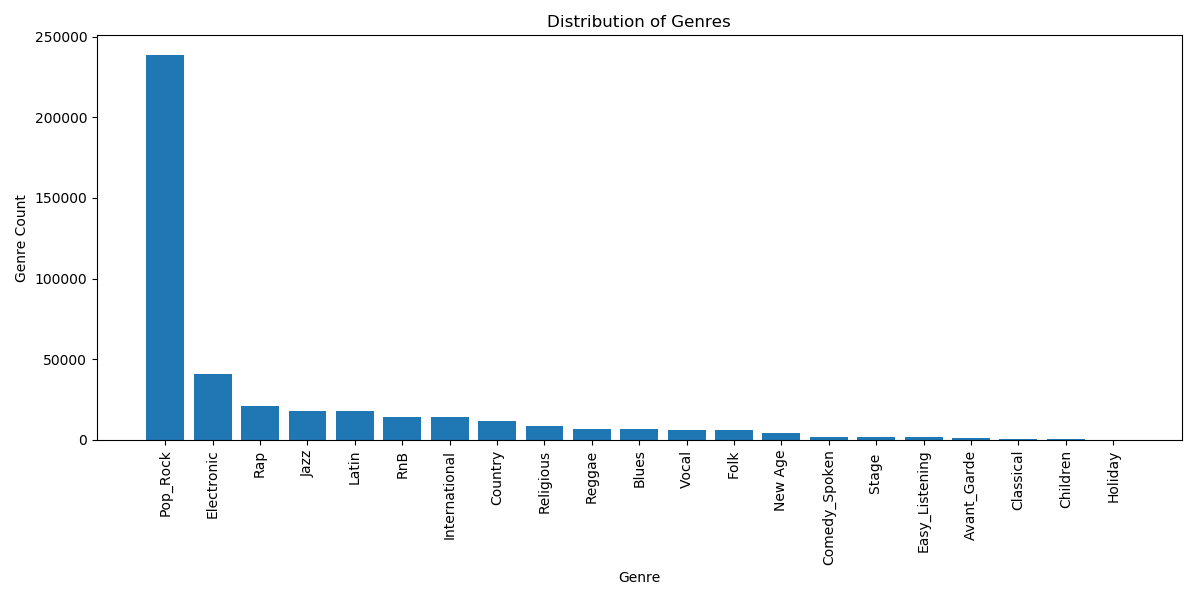

In [107]:
# Convert the DataFrame to a Pandas DataFrame for easy plotting
genre_counts_pd = genre_counts.toPandas()

# Sort the DataFrame by 'GenreCount' in descending order
genre_counts_pd = genre_counts_pd.sort_values(by='GenreCount', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_pd['Genre'], genre_counts_pd['GenreCount'])
plt.xlabel('Genre')
plt.ylabel('Genre Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=90)  
plt.tight_layout()

# Show the plot
plt.show()


### Q1(c) Merge the genres dataset and the audio features dataset so that every song has a label.

In [102]:
audio_feature_genre = audio_feature.join(magd,audio_feature.MSD_TRACKID == magd.MAGD_TRACKID,"left")
show_as_html(audio_feature_genre)

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre
0,0.17850,12.050,523.0,27450.0,3962000.0,0.40740,35.72,2024.0,189600.0,31440000.0,TRBCWYZ128F92D11BE,None,None
1,0.04672,6.039,474.4,42770.0,8109000.0,0.08021,13.15,734.5,101400.0,19010000.0,TRBPGDU12903CDCA73,None,None
2,0.23570,12.240,521.5,33500.0,4729000.0,0.43700,32.02,1763.0,185400.0,32200000.0,TRBSSIQ128F147ADC3,TRBSSIQ128F147ADC3,Rap
3,0.24880,14.250,718.5,43490.0,6852000.0,0.41390,27.33,1708.0,166400.0,27880000.0,TRCDLQC128F1469A07,None,None
4,0.20100,9.769,623.8,50040.0,7310000.0,0.36060,21.53,799.9,54530.0,6996000.0,TRCFWHT128F92EF362,None,None
5,0.19620,10.360,586.1,36770.0,5757000.0,0.49580,27.55,1286.0,86400.0,10950000.0,TRCPUYY128F428E377,TRCPUYY128F428E377,Rap
6,0.23170,10.400,567.1,32440.0,4945000.0,0.53610,24.84,1567.0,167600.0,28420000.0,TRCTBPD128F425B77D,TRCTBPD128F425B77D,Rap
7,0.13610,7.687,439.3,29260.0,4456000.0,0.28150,25.02,1530.0,172800.0,29340000.0,TRCUEXN128F42783D7,TRCUEXN128F42783D7,Country
8,0.02078,23.870,1223.0,97550.0,16280000.0,0.01717,30.31,1599.0,127900.0,21260000.0,TRCYRYT128F425E486,TRCYRYT128F425E486,Pop_Rock
9,0.14420,18.020,586.8,53700.0,4234000.0,0.33710,43.35,2621.0,162900.0,27950000.0,TRDBRAH128F42B99CB,TRDBRAH128F42B99CB,Electronic


In [103]:
null_genre_count = audio_feature_genre.filter(F.col("Genre").isNull()).count()
print(null_genre_count)
print(audio_feature_genre.count())
print(null_genre_count/audio_feature_genre.count())

574003
994623
0.5771060994969953


In [104]:
# Drop rows with null Genre values
audio_feature_genre_new = audio_feature_genre.na.drop(subset=["Genre"])
print(audio_feature_genre_new.count())
show_as_html(audio_feature_genre_new)

420620


,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock


### Q2(a) Research and choose three classification algorithms from the spark.ml library.
### Justify your choice of algorithms, taking into account considerations such as explainability,interpretability, predictive accuracy, training speed, hyperparameter tuning, dimensionality,and issues with scaling.
### Based on the descriptive statistics from Q1 part (a), decide what processing you shouldapply to the audio features before using them to train each model.

In [105]:
# logistic regression data propressing(drop column + scale)

# remove the column with high correlation
logistic_df = audio_feature_genre_new.drop("Method_of_Moments_Overall_Average_4")

assembler = VectorAssembler(
        inputCols=[col for col in logistic_df.columns if col.startswith("Method")],
        outputCol="features"
        )
scale_data_logistic = assembler.transform(logistic_df)


# Define StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Compute summary statistics and generate StandardScalerModel
scalerModel = scaler.fit(scale_data_logistic)

# Normalize each feature to have unit standard deviation and zero mean
scaled_logistic = scalerModel.transform(scale_data_logistic)

show_as_html(scaled_logistic)


,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000576, -0.1981325052821773, -0..."
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681651, -0.36237500287129903, 0...."
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986845, -0.3503305530480966, -0...."
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423315, 0.5472546962764541, 0.21..."
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077652, -0.8726216953815041, -0...."
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.3208369887371258, -0.16747390573220786, 0...."
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.3191914396630329, 0.05726457846890708, 0.13..."
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130454, 1.6668410548423007, 1.20..."
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719114, 1.4834369325344485, 0.645..."
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.0321342831982687, 1.6422046802039323, 0.46..."


In [106]:
# random forest + GBT preprocessing(scale)

assembler = VectorAssembler(
    inputCols=[col for col in audio_feature_genre_new.columns if col.startswith("Method")],
    outputCol="features"
)
scale_data_rf_gbt = assembler.transform(audio_feature_genre_new)

# Define StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Compute summary statistics and generate StandardScalerModel
scalerModel = scaler.fit(scale_data_rf_gbt)

# Normalize each feature to have unit standard deviation and zero mean
scaled_rf_gbt = scalerModel.transform(scale_data_rf_gbt)

show_as_html(scaled_rf_gbt)

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000704, -0.19813250528217827, -..."
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681665, -0.3623750028713, 0.2035..."
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986858, -0.35033055304809757, -0..."
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423186, 0.5472546962764531, 0.21..."
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077665, -0.872621695381505, -0.7..."
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.32083698873712707, -0.16747390573220883, 0..."
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.31919143966303165, 0.057264578468906105, 0...."
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130467, 1.6668410548422996, 1.20..."
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719103, 1.4834369325344474, 0.645..."
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.0321342831982698, 1.6422046802039314, 0.46..."


### Q2(b) Convert the genre column into a binary column that represents if the song is ”Electronic” or some other genre.
### What is the class balance of the binary label?


In [29]:
# Define a UDF to convert Genre to binary label
genre_to_binary_udf = F.udf(lambda genre: 1 if genre == "Electronic" else 0, IntegerType())

# Apply the UDF to create a new column 'IsElectronic'
scaled_logistic = scaled_logistic.withColumn("label", genre_to_binary_udf(scaled_logistic["Genre"]))
scaled_rf_gbt = scaled_rf_gbt.withColumn("label", genre_to_binary_udf(scaled_rf_gbt["Genre"]))
show_as_html(scaled_logistic)
show_as_html(scaled_rf_gbt)
print_class_balance(scaled_logistic, "scaled_logistic")
print_class_balance(scaled_rf_gbt, "scaled_rf_gbt")

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures,label
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000243, -0.19813250528218118, -...",0
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681616, -0.3623750028713029, 0.2...",0
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986807, -0.3503305530481005, -0....",0
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423608, 0.5472546962764502, 0.21...",0
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077617, -0.872621695381508, -0.7...",0
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.3208369887371226, -0.16747390573221174, 0....",0
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.3191914396630357, 0.05726457846890319, 0.13...",0
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130419, 1.6668410548422967, 1.20...",1
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719138, 1.4834369325344445, 0.645...",0
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.032134283198265, 1.6422046802039285, 0.463...",0


,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures,label
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000243, -0.19813250528218168, -...",0
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681616, -0.3623750028713034, 0.2...",0
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986807, -0.350330553048101, -0.4...",0
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423608, 0.5472546962764497, 0.21...",0
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077617, -0.8726216953815085, -0....",0
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.3208369887371226, -0.16747390573221224, 0....",0
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.3191914396630357, 0.057264578468902705, 0.1...",0
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130419, 1.6668410548422963, 1.20...",1
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719138, 1.483436932534444, 0.6453...",0
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.032134283198265, 1.642204680203928, 0.4636...",0


dataset: scaled_logistic
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319

dataset: scaled_rf_gbt
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319



### Q2(c) Split the dataset into training and test sets. You should use stratified random sampling to make sure the class balanced is preserved. You may also want to use a resampling method such as subsampling, oversampling, or observation weighting. Justify your overall approach and your choice of resampling method.

In [30]:
# split the data for logistic regression

# Exact stratification using Window (binary, counts hard coded)

temp = (
    scaled_logistic
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training_logistic = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379954  * 0.8)) |  
    ((F.col("label") == 1) & (F.col("row") < 40666    * 0.8))    
)
training_logistic.cache()

test_logistic = temp.join(training_logistic, on="id", how="left_anti")
test_logistic.cache()

training_logistic = training_logistic.drop("id", "random", "row")
test_logistic = test_logistic.drop("id", "random", "row")

print_class_balance(scaled_logistic, "scaled_logistic")
print_class_balance(training_logistic, "training_logistic")
print_class_balance(test_logistic, "test_logistic")

dataset: scaled_logistic
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319

dataset: training_logistic
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

dataset: test_logistic
total:   84125
counts:
   label  count     ratio
0      1   8134  0.096689
1      0  75991  0.903311



In [31]:
# split the data for random forest and GBT

# Exact stratification using Window (binary, counts hard coded)

temp = (
    scaled_rf_gbt
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training_rf_gbt = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379954  * 0.8)) |  
    ((F.col("label") == 1) & (F.col("row") < 40666    * 0.8))    
)
training_rf_gbt.cache()

test_rf_gbt = temp.join(training_rf_gbt, on="id", how="left_anti")
test_rf_gbt.cache()

training_rf_gbt = training_rf_gbt.drop("id", "random", "row")
test_rf_gbt = test_rf_gbt.drop("id", "random", "row")

print_class_balance(scaled_rf_gbt, "scaled_rf_gbt")
print_class_balance(training_rf_gbt, "training_rf_gbt")
print_class_balance(test_rf_gbt, "test_rf_gbt")

dataset: scaled_rf_gbt
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319

dataset: training_rf_gbt
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

dataset: test_rf_gbt
total:   84125
counts:
   label  count     ratio
0      1   8134  0.096689
1      0  75991  0.903311



In [32]:
# subsampling for logistic regression

training_downsampled_logistic = (
    training_logistic
    .withColumn("random", F.rand())
    .where(
        ((F.col("label") == 1)) |
        ((F.col("label") == 0) & (F.col("random") < (100000 / 303963)))
    )
)
training_downsampled_logistic.cache()

print_class_balance(training_downsampled_logistic, "training (downsampled)_logistic")



dataset: training (downsampled)_logistic
total:   132056
counts:
   label  count    ratio
0      1  32532  0.24635
1      0  99524  0.75365



In [33]:
# subsampling for random forest and GBT

training_downsampled_rf_gbt = (
    training_rf_gbt
    .withColumn("random", F.rand())
    .where(
        ((F.col("label") == 1)) |
        ((F.col("label") == 0) & (F.col("random") < (100000 / 303963)))
    )
)
training_downsampled_rf_gbt.cache()

print_class_balance(training_downsampled_rf_gbt, "training (downsampled)_rf_gbt")


dataset: training (downsampled)_rf_gbt
total:   132951
counts:
   label   count     ratio
0      1   32532  0.244692
1      0  100419  0.755308



In [34]:
# oversampling for logistic regression

# Counts for upsampling / downsampling

counts = {
    label: count for label, count in training_logistic.groupBy("label").count().collect()
}
print(counts)


count_lower_bound = 60000
count_upper_bound = 200000

def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  # do nothing

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)
training_oversampled_logistic = (
    training_logistic
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
    .select(
        F.col("MSD_TRACKID"),
        F.col("label"),
        F.col("scaledFeatures"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

print_class_balance(training_oversampled_logistic, "training (oversampled)_logistic")



{1: 32532, 0: 303963}
dataset: training (oversampled)_logistic
total:   260056
counts:
   label   count     ratio
0      1   59927  0.230439
1      0  200129  0.769561



In [35]:
# oversampling for random forest and GBT

# Counts for upsampling / downsampling

counts = {
    label: count for label, count in training_rf_gbt.groupBy("label").count().collect()
}
print(counts)


count_lower_bound = 60000
count_upper_bound = 200000

def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  # do nothing

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)
training_oversampled_rf_gbt = (
    training_rf_gbt
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
    .select(
        F.col("MSD_TRACKID"),
        F.col("label"),
        F.col("scaledFeatures"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

print_class_balance(training_oversampled_rf_gbt, "training (oversampled)_rf_gbt")



{1: 32532, 0: 303963}
dataset: training (oversampled)_rf_gbt
total:   259463
counts:
   label   count     ratio
0      1   59859  0.230703
1      0  199604  0.769297



In [36]:
# Observation reweighting for logistic regression

training_weighted_logistic = training_logistic.withColumn(
    "weight",
    F.when(F.col("label") == 0, 1).when(F.col("label") == 1, 5).otherwise(1.0)
)

weights = (
    training_weighted_logistic
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)
print_class_balance(training_weighted_logistic, "training (weighted)_logistic")


   label weights
0      1   [5.0]
1      0   [1.0]
dataset: training (weighted)_logistic
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321



In [37]:
# Observation reweighting for random forest and GBT

training_weighted_rf_gbt = training_rf_gbt.withColumn(
    "weight",
    F.when(F.col("label") == 0, 1).when(F.col("label") == 1, 5).otherwise(1.0)
)

weights = (
    training_weighted_rf_gbt
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)
print_class_balance(training_weighted_rf_gbt, "training (weighted)_rf_gbt")


   label weights
0      1   [5.0]
1      0   [1.0]
dataset: training (weighted)_rf_gbt
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321



### Q2(d) Train each of the three classification algorithms that you chose in part (a).
### Q2(e) Use the test set to compute the compute a range of performance metrics for each model,
### such as precision, accuracy, and recall.

In [43]:
# logistic regression

# No sampling

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')

# Fit the Logistic Regression model on the training data
lr_model = lr.fit(training_logistic)

# Make predictions on the test data
pred_logistic_test = lr_model.transform(test_logistic)
pred_logistic_test.cache()
# pred_logistic_train = lr_model.transform(training_logistic)
# print_metrics(pred_logistic_train)
print_metrics(pred_logistic_test)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        331
nN:        83794

TP         163
FP         168
FN         7971
TN         75823

precision: 0.49244713
recall:    0.02003934
F1 score:  0.03851152
accuracy:  0.90325111

auroc:     0.74906706



In [98]:
# random forest

# No sampling

from pyspark.ml.classification import RandomForestClassifier
# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training_rf_gbt)

# Make predictions on the test data
pred_rf = rf_model.transform(test_rf_gbt)

pred_rf.cache()

print_metrics(pred_rf)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        0
nN:        84125

TP         0
FP         0
FN         8134
TN         75991

precision: 0.00000000
recall:    0.00000000
F1 score:  0.00000000
accuracy:  0.90331055

auroc:     0.76204153



In [99]:
# GBT

# No sampling

from pyspark.ml.classification import GBTClassifier

# Create a GBTClassifier model
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label', maxIter=100, seed=42)  

# Fit the GBTClassifier model on the training data
gbt_model = gbt.fit(training_rf_gbt)

# Make predictions on the test data
pred_gbt = gbt_model.transform(test_rf_gbt)

# Cache the predictions for performance if needed
pred_gbt.cache()

# Print metrics 
print_metrics(pred_gbt)


metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        2138
nN:        81987

TP         1355
FP         783
FN         6779
TN         75208

precision: 0.63376988
recall:    0.16658471
F1 score:  0.26382399
accuracy:  0.91010996

auroc:     0.81747770



In [44]:
# logistic regression

# subsampling

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')

# Fit the Logistic Regression model on the training data
lr_model = lr.fit(training_downsampled_logistic)

# Make predictions on the test data
pred_logistic_test = lr_model.transform(test_logistic)
pred_logistic_test.cache()
# pred_logistic_train = lr_model.transform(training_downsampled_logistic)
# print("Train")
# print_metrics(pred_logistic_train)
print("Test")
print_metrics(pred_logistic_test)

Test
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        5189
nN:        78936

TP         1933
FP         3256
FN         6201
TN         72735

precision: 0.37251879
recall:    0.23764446
F1 score:  0.29017489
accuracy:  0.88758395

auroc:     0.74945062



In [45]:
# random forest

# subsampling

from pyspark.ml.classification import RandomForestClassifier
# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training_downsampled_rf_gbt)

# Make predictions on the test data
pred_rf_test = rf_model.transform(test_rf_gbt)
pred_rf_test.cache()
# pred_rf_train = rf_model.transform(training_downsampled_rf_gbt)
# print("Train")
# print_metrics(pred_rf_train)
print("Test")
print_metrics(pred_rf_test)


Test
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        4536
nN:        79589

TP         2016
FP         2520
FN         6118
TN         73471

precision: 0.44444444
recall:    0.24784854
F1 score:  0.31823204
accuracy:  0.89731947

auroc:     0.77882703



In [46]:
# GBT

# subsampling

from pyspark.ml.classification import GBTClassifier

# Create a GBTClassifier model
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label', maxIter=100, seed=42)  

# Fit the GBTClassifier model on the training data
gbt_model = gbt.fit(training_downsampled_rf_gbt)

# Make predictions on the test data
# pred_gbt = gbt_model.transform(test_rf_gbt)

# # Cache the predictions for performance if needed
# pred_gbt.cache()

# # Print metrics 
# print_metrics(pred_gbt)


pred_gbt_test = gbt_model.transform(test_rf_gbt)
pred_gbt_test.cache()
# pred_gbt_train = gbt_model.transform(training_downsampled_rf_gbt)
# print("Train")
# print_metrics(pred_gbt_train)
print("Test")
print_metrics(pred_gbt_test)


Test
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        8241
nN:        75884

TP         3509
FP         4732
FN         4625
TN         71259

precision: 0.42579784
recall:    0.43139907
F1 score:  0.42858015
accuracy:  0.88877266

auroc:     0.82187121



In [103]:
# GBT

# oversampling

from pyspark.ml.classification import GBTClassifier

# Create a GBTClassifier model
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label', maxIter=100, seed=42)  

# Fit the GBTClassifier model on the training data
gbt_model = gbt.fit(training_oversampled_rf_gbt)

# Make predictions on the test data
pred_gbt = gbt_model.transform(test_rf_gbt)

# Cache the predictions for performance if needed
pred_gbt.cache()

# Print metrics 
print_metrics(pred_gbt)


metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        7360
nN:        76765

TP         3277
FP         4083
FN         4857
TN         71908

precision: 0.44524457
recall:    0.40287681
F1 score:  0.42300245
accuracy:  0.89372957

auroc:     0.82165536



In [104]:
# random forest

# oversampling

from pyspark.ml.classification import RandomForestClassifier
# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training_oversampled_rf_gbt)

# Make predictions on the test data
pred_rf = rf_model.transform(test_rf_gbt)

pred_rf.cache()

print_metrics(pred_rf)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        3925
nN:        80200

TP         1797
FP         2128
FN         6337
TN         73863

precision: 0.45783439
recall:    0.22092451
F1 score:  0.29803466
accuracy:  0.89937593

auroc:     0.77940810



In [105]:
# logistic regression

# oversampling

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')

# Fit the Logistic Regression model on the training data
lr_model = lr.fit(training_oversampled_logistic)

# Make predictions on the test data
pred_logistic = lr_model.transform(test_logistic)
pred_logistic.cache()

print_metrics(pred_logistic)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        4492
nN:        79633

TP         1730
FP         2762
FN         6404
TN         73229

precision: 0.38512912
recall:    0.21268748
F1 score:  0.27403770
accuracy:  0.89104309

auroc:     0.75075707



In [106]:
# GBT

# Observation reweighting

from pyspark.ml.classification import GBTClassifier

# Create a GBTClassifier model
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label', maxIter=100, seed=42)  

# Fit the GBTClassifier model on the training data
gbt_model = gbt.fit(training_weighted_rf_gbt)

# Make predictions on the test data
pred_gbt = gbt_model.transform(test_rf_gbt)

# Cache the predictions for performance if needed
pred_gbt.cache()

# Print metrics 
print_metrics(pred_gbt)


metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        2138
nN:        81987

TP         1355
FP         783
FN         6779
TN         75208

precision: 0.63376988
recall:    0.16658471
F1 score:  0.26382399
accuracy:  0.91010996

auroc:     0.81748157



In [107]:
# random forest

# Observation reweighting

from pyspark.ml.classification import RandomForestClassifier
# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training_weighted_rf_gbt)

# Make predictions on the test data
pred_rf = rf_model.transform(test_rf_gbt)

pred_rf.cache()

print_metrics(pred_rf)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        0
nN:        84125

TP         0
FP         0
FN         8134
TN         75991

precision: 0.00000000
recall:    0.00000000
F1 score:  0.00000000
accuracy:  0.90331055

auroc:     0.76206717



In [108]:
# logistic regression

# Observation reweighting

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')

# Fit the Logistic Regression model on the training data
lr_model = lr.fit(training_weighted_logistic)

# Make predictions on the test data
pred_logistic = lr_model.transform(test_logistic)
pred_logistic.cache()

print_metrics(pred_logistic)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        339
nN:        83786

TP         163
FP         176
FN         7971
TN         75815

precision: 0.48082596
recall:    0.02003934
F1 score:  0.03847516
accuracy:  0.90315602

auroc:     0.75068193



### Q4(b) Convert the genre column into an integer index that encodes each genre consistently. Find a way to do this that requires the least amount of work by hand.

In [123]:
from pyspark.ml.feature import StringIndexer

df = scaled_rf_gbt

# Create a StringIndexer object, specifying the input and output columns
indexer = StringIndexer(inputCol="Genre", outputCol="label")

# Use StringIndexer to transform the data
indexedDF = indexer.fit(df).transform(df)
indexedDF = indexedDF.withColumn("label",F.col("label").cast("int"))

show_as_html(indexedDF)

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures,label
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000704, -0.19813250528217827, -...",0
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681665, -0.3623750028713, 0.2035...",0
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986858, -0.35033055304809757, -0...",0
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423186, 0.5472546962764531, 0.21...",2
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077665, -0.872621695381505, -0.7...",6
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.32083698873712707, -0.16747390573220883, 0...",0
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.31919143966303165, 0.057264578468906105, 0....",6
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130467, 1.6668410548422996, 1.20...",1
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719103, 1.4834369325344474, 0.645...",9
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.0321342831982698, 1.6422046802039314, 0.46...",0


### Q4(c) Split your dataset into training and test sets, train the classification algorithm that you chose in part (b), and compute a range of performance metrics that are relevant to multiclass classification. Make sure you take into account the class balance in your comments.

In [124]:
print_class_balance(indexedDF,"indexedDF")

dataset: indexedDF
total:   420620
counts:
    label   count     ratio
0      12    5789  0.013763
1      18     555  0.001319
2      10    6801  0.016169
3       1   40666  0.096681
4       3   17775  0.042259
5      20     200  0.000475
6      13    4000  0.009510
7      14    2067  0.004914
8       9    6931  0.016478
9       6   14194  0.033745
10     11    6182  0.014697
11      7   11691  0.027795
12      0  237649  0.564997
13      8    8780  0.020874
14     16    1535  0.003649
15      5   14314  0.034031
16      2   20899  0.049686
17     17    1012  0.002406
18     15    1613  0.003835
19     19     463  0.001101
20      4   17504  0.041615



In [125]:
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    indexedDF
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    indexedDF
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(indexedDF, "indexedDF")
print_class_balance(training, "training")
print_class_balance(test, "test")

{12: 5789, 18: 555, 10: 6801, 3: 17775, 1: 40666, 20: 200, 13: 4000, 14: 2067, 6: 14194, 9: 6931, 11: 6182, 7: 11691, 0: 237649, 8: 8780, 16: 1535, 5: 14314, 2: 20899, 17: 1012, 15: 1613, 19: 463, 4: 17504}
dataset: indexedDF
total:   420620
counts:
    label   count     ratio
0      12    5789  0.013763
1      18     555  0.001319
2      10    6801  0.016169
3       1   40666  0.096681
4       3   17775  0.042259
5      20     200  0.000475
6      13    4000  0.009510
7      14    2067  0.004914
8       9    6931  0.016478
9       6   14194  0.033745
10     11    6182  0.014697
11      7   11691  0.027795
12      0  237649  0.564997
13      8    8780  0.020874
14     16    1535  0.003649
15      5   14314  0.034031
16      2   20899  0.049686
17     17    1012  0.002406
18     15    1613  0.003835
19     19     463  0.001101
20      4   17504  0.041615

dataset: training
total:   336483
counts:
    label   count     ratio
0      12    4631  0.013763
1      18     443  0.001317
2      

In [126]:
show_as_html(indexedDF)

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,MAGD_TRACKID,Genre,features,scaledFeatures,label
0,0.13080,9.587,459.9,27280.0,4303000.0,0.24740,26.02,1067.0,67790.0,8281000.0,TRAAABD128F429CF47,TRAAABD128F429CF47,Pop_Rock,"[0.1308, 9.587, 459.9, 27280.0, 4303000.0, 0.2...","[-0.43987609257000704, -0.19813250528217827, -...",0
1,0.10690,8.987,562.6,43100.0,7057000.0,0.10070,22.90,1346.0,157700.0,27380000.0,TRAAGTO128F1497E3C,TRAAGTO128F1497E3C,Pop_Rock,"[0.1069, 8.987, 562.6, 43100.0, 7057000.0, 0.1...","[-0.8093611031681665, -0.3623750028713, 0.2035...",0
2,0.08485,9.031,445.9,23750.0,3274000.0,0.25830,35.59,2015.0,198400.0,33360000.0,TRAAHAU128F9313A3D,TRAAHAU128F9313A3D,Pop_Rock,"[0.08485, 9.031, 445.9, 23750.0, 3274000.0, 0....","[-1.1502458095986858, -0.35033055304809757, -0...",0
3,0.16540,12.310,565.1,33100.0,5273000.0,0.18610,38.38,1962.0,196600.0,33550000.0,TRAAHZP12903CA25F4,TRAAHZP12903CA25F4,Rap,"[0.1654, 12.31, 565.1, 33100.0, 5273000.0, 0.1...","[0.09502689348423186, 0.5472546962764531, 0.21...",2
4,0.11040,7.123,398.2,19540.0,3240000.0,0.28710,28.53,1807.0,189400.0,31560000.0,TRAAICW128F1496C68,TRAAICW128F1496C68,International,"[0.1104, 7.123, 398.2, 19540.0, 3240000.0, 0.2...","[-0.7552524196077665, -0.872621695381505, -0.7...",6
5,0.13850,9.699,581.6,31590.0,4569000.0,0.37060,23.63,1554.0,163800.0,27200000.0,TRAAMFF12903CE8107,TRAAMFF12903CE8107,Pop_Rock,"[0.1385, 9.699, 581.6, 31590.0, 4569000.0, 0.3...","[-0.32083698873712707, -0.16747390573220883, 0...",0
6,0.17990,10.520,551.4,29170.0,4396000.0,0.40460,30.78,1806.0,183200.0,30590000.0,TRAAMHG128F92ED7B2,TRAAMHG128F92ED7B2,International,"[0.1799, 10.52, 551.4, 29170.0, 4396000.0, 0.4...","[0.31919143966303165, 0.057264578468906105, 0....",6
7,0.11920,16.400,737.3,41670.0,6295000.0,0.22840,31.04,1878.0,169100.0,28290000.0,TRAAROH128F42604B0,TRAAROH128F42604B0,Electronic,"[0.1192, 16.4, 737.3, 41670.0, 6295000.0, 0.22...","[-0.6192077295130467, 1.6668410548422996, 1.20...",1
8,0.22760,15.730,639.9,44820.0,5118000.0,0.47390,34.46,1963.0,174800.0,29860000.0,TRAAUIH128F4254C9D,TRAAUIH128F4254C9D,Reggae,"[0.2276, 15.73, 639.9, 44820.0, 5118000.0, 0.4...","[1.0566154984719103, 1.4834369325344474, 0.645...",9
9,0.09249,16.310,608.1,50830.0,5021000.0,0.15200,30.55,1889.0,130100.0,17830000.0,TRAAUQF12903CC4A4D,TRAAUQF12903CC4A4D,Pop_Rock,"[0.09249, 16.31, 608.1, 50830.0, 5021000.0, 0....","[-1.0321342831982698, 1.6422046802039314, 0.46...",0


In [127]:
# random forest

from pyspark.ml.classification import RandomForestClassifier

# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training)

# Make predictions on the test data
pred_rf = rf_model.transform(test)

pred_rf.cache()





DataFrame[Method_of_Moments_Overall_Standard_Deviation_1: double, Method_of_Moments_Overall_Standard_Deviation_2: double, Method_of_Moments_Overall_Standard_Deviation_3: double, Method_of_Moments_Overall_Standard_Deviation_4: double, Method_of_Moments_Overall_Standard_Deviation_5: double, Method_of_Moments_Overall_Average_1: double, Method_of_Moments_Overall_Average_2: double, Method_of_Moments_Overall_Average_3: double, Method_of_Moments_Overall_Average_4: double, Method_of_Moments_Overall_Average_5: double, MSD_TRACKID: string, MAGD_TRACKID: string, Genre: string, features: vector, scaledFeatures: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [128]:
def metrics_per_class(pred_rf, class_id):
    # calculate precision and recall
    TP = pred_rf.filter((pred_rf["label"] == class_id) & (pred_rf["prediction"] == class_id)).count()
    FP = pred_rf.filter((pred_rf["label"] == class_id) & (pred_rf["prediction"] != class_id)).count()
    TN = pred_rf.filter((pred_rf["label"] != class_id) & (pred_rf["prediction"] != class_id)).count()
    FN = pred_rf.filter((pred_rf["label"] != class_id) & (pred_rf["prediction"] == class_id)).count()
                                 
    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0
                                 
    return precision, recall


In [129]:
from pyspark.sql.functions import col

class_labels = [str (row.label) for row in pred_rf.select("label").distinct().collect()]

# Calculate label counts
label_counts = pred_rf.groupBy("label").count()

# Convert label column to string for joining
label_counts = label_counts.withColumn("label", label_counts["label"].cast("string"))

# Create a DataFrame with class-specific metrics
metrics_df = []
for label in class_labels:
    precision, recall = metrics_per_class(pred_rf, label)
    metrics_df.append({"label": label, "precision": float(precision), "recall": float(recall)})

# Convert the list of dictionaries to a DataFrame
metrics_df = spark.createDataFrame(metrics_df)

# Join metrics_df with label_counts
metrics_df = metrics_df.join(label_counts, on="label", how="left")

# Show the DataFrame
show_as_html(metrics_df)


,label,precision,recall,count
0,16,0.000000,0.000000,308
1,12,0.000000,0.000000,1158
2,0,0.992847,0.571626,47530
3,10,0.000000,0.000000,1361
4,6,0.000000,0.000000,2839
5,17,0.000000,0.000000,203
6,13,0.000000,0.000000,801
7,1,0.101303,0.520531,8134
8,7,0.000000,0.000000,2339
9,18,0.000000,0.000000,112


In [130]:
# downsampling 

count_lower_bound = 12000
count_upper_bound = 20000

def random_resample(x, y, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [1] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if y < (count_upper_bound / count): # randomly downsample to count_upper_bound
            return [1]
        else:
            return []

    return [1]  # do nothing

random_resample_udf = F.udf(
    lambda x, y: random_resample(x, y, counts, count_lower_bound, count_upper_bound),
    ArrayType(IntegerType())
)
training_rf = (
    indexedDF
    .withColumn("rand", F.rand())
    .withColumn("sample", random_resample_udf(F.col("label"), F.col("rand")))
    .select(
        F.col("MSD_TRACKID"),
        F.col("label"),
        F.col("scaledFeatures"),
        F.explode(F.col("sample")).alias("sample")  # note that explode on [] will effectively drop the row
    )
    .drop("sample")
)

print_class_balance(training_rf, "training_rf")



dataset: training_rf
total:   291926
counts:
    label  count     ratio
0      12  11936  0.040887
1      18  11759  0.040281
2      10  11959  0.040966
3       3  17775  0.060889
4       1  19920  0.068236
5      20  12161  0.041658
6      13  12029  0.041206
7      14  11948  0.040928
8       9  11916  0.040819
9       6  14194  0.048622
10     11  12007  0.041130
11      7  12017  0.041165
12      0  19950  0.068339
13      8  12076  0.041367
14     16  11802  0.040428
15      5  14314  0.049033
16      2  20006  0.068531
17     17  11902  0.040771
18     15  11975  0.041021
19     19  11853  0.040603
20      4  17504  0.059960



In [131]:
# Create a RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='label', numTrees=200, seed=42) 

# Fit the RandomForestClassifier model on the training data
rf_model = rf.fit(training_rf)

# Make predictions on the test data
pred_rf_downsample = rf_model.transform(test)

pred_rf_downsample.cache()


DataFrame[Method_of_Moments_Overall_Standard_Deviation_1: double, Method_of_Moments_Overall_Standard_Deviation_2: double, Method_of_Moments_Overall_Standard_Deviation_3: double, Method_of_Moments_Overall_Standard_Deviation_4: double, Method_of_Moments_Overall_Standard_Deviation_5: double, Method_of_Moments_Overall_Average_1: double, Method_of_Moments_Overall_Average_2: double, Method_of_Moments_Overall_Average_3: double, Method_of_Moments_Overall_Average_4: double, Method_of_Moments_Overall_Average_5: double, MSD_TRACKID: string, MAGD_TRACKID: string, Genre: string, features: vector, scaledFeatures: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [132]:
from pyspark.sql.functions import col

class_labels = [str (row.label) for row in pred_rf_downsample.select("label").distinct().collect()]

# Calculate label counts
label_counts = pred_rf_downsample.groupBy("label").count()

# Convert label column to string for joining
label_counts = label_counts.withColumn("label", label_counts["label"].cast("string"))

# Create a DataFrame with class-specific metrics
metrics_df_downsample = []
for label in class_labels:
    precision, recall = metrics_per_class(pred_rf_downsample, label)
    metrics_df_downsample.append({"label": label, "precision": float(precision), "recall": float(recall)})

# Convert the list of dictionaries to a DataFrame
metrics_df_downsample = spark.createDataFrame(metrics_df_downsample)

# Join metrics_df with label_counts
metrics_df_downsample = metrics_df_downsample.join(label_counts, on="label", how="left")

# Show the DataFrame
show_as_html(metrics_df_downsample)

,label,precision,recall,count
0,16,0.198052,0.030917,308
1,12,0.000000,0.000000,1158
2,0,0.507006,0.795576,47530
3,10,0.055107,0.078947,1361
4,6,0.000000,0.000000,2839
5,17,0.187192,0.038345,203
6,13,0.152310,0.120316,801
7,1,0.199779,0.338260,8134
8,7,0.089782,0.111940,2339
9,18,0.223214,0.035211,112


# Song Recommendations

### Q1(a) Based on the size, format, and number of rows, do you think you should repartition and cache the Taste Profile dataset to improve efficiency when training a collaborative filtering model?

In [154]:
!hdfs dfs -du -h /data/msd/tasteprofile

2.0 M    16.2 M  /data/msd/tasteprofile/mismatches
488.4 M  3.8 G   /data/msd/tasteprofile/triplets.tsv


In [24]:
show_as_html(taste_triplets_new)

,User,Song,PlayCount
0,a30335f2e975ac7731588c6ae2c81404d1027ea6,SOAJXWO12A8C1436D0,1.0
1,97429ec2a2f79493396be5cc32e37b821b516156,SOJUJNJ12A6D4F9C61,3.0
2,5d69038f84cd6b2b7116e1cfc3ed2c22c6bd800f,SOPNUMV12A8C139236,3.0
3,cb14d24f635d2a3016cd1e361619424173920b7f,SOBPRZE12A8C1313CC,7.0
4,1a7394e05fe2ca261f60aef701c71956dbb5c7d2,SOJWRRP12AB01886A9,2.0
5,a817b6e3b252e2f9daa5d1f4ac8c3eafc485a088,SOKOSPK12A8C13C088,4.0
6,6e2f879286c020be768d29515aab6a8388998d88,SOGQXAL12AB017E7E7,2.0
7,4f227b60a54c1b82a5748841c70bbc628f601e8f,SOCFYUZ12AF729E4B6,2.0
8,7b388f3affbefccd0a49a23eb3771ed43e6136eb,SOJGXPU12AB017CF94,1.0
9,cdbaa1bfea8d15fb336ae8e5b096b5f7c65e87a1,SOQOAGD12AB01809FB,1.0


In [25]:
taste_triplets_new.printSchema()

root
 |-- User: string (nullable = true)
 |-- Song: string (nullable = true)
 |-- PlayCount: double (nullable = true)



### Q1(b) How many unique songs are there in the dataset? How many unique users?

In [26]:
# Count unique songs
unique_song_count = taste_triplets_new.select("Song").distinct().count()

# Count unique users
unique_user_count = taste_triplets_new.select("User").distinct().count()

# Display the counts
print("Unique Song Count:", unique_song_count)
print("Unique User Count:", unique_user_count)

Unique Song Count: 378310
Unique User Count: 1019318


### Q1(c) How many different songs has the most active user played?What is this as a percentage of the total number of unique songs in the dataset?


In [29]:
# Calculate the total PlayCount for each user
user_total_playcount = taste_triplets_new.groupBy("User").agg(F.sum("PlayCount").alias("TotalPlayCount"))

# Find the most active user with the highest total PlayCount
most_active_user = user_total_playcount.orderBy(F.col("TotalPlayCount").desc()).first()["User"]

# Calculate the number of different songs played by the most active user
distinct_song_count = taste_triplets_new.filter(taste_triplets_new["User"] == most_active_user) \
                    .agg(F.countDistinct("Song").alias("DistinctSongCount")).first()["DistinctSongCount"]
print("The most active user has played", distinct_song_count, "different songs.")

The most active user has played 195 different songs.


In [30]:
percentage = (distinct_song_count / unique_song_count) * 100

print(f"{percentage:.2f}% of the total unique songs in the dataset.")

0.05% of the total unique songs in the dataset.


### Q1(d) Visualize the distribution of song popularity and the distribution of user activity by collecting the counts of user plays per song and the counts of song plays per user respectively, and describe the shape of the distributions.

In [156]:
# Calculate counts of user plays per song and counts of song plays per user
song_counts = taste_triplets_new.groupBy("Song").agg(F.sum("PlayCount").alias("SongCount"))
user_counts = taste_triplets_new.groupBy("User").agg(F.sum("PlayCount").alias("UserCount"))


<IPython.core.display.Javascript object>


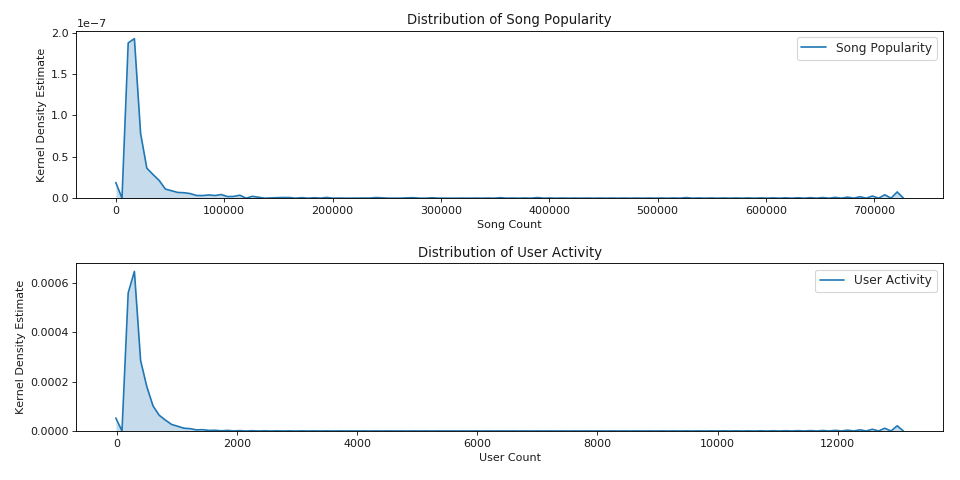

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
song_counts_pd = song_counts.toPandas()
user_counts_pd = user_counts.toPandas()

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.set(style="whitegrid")

# Plot the distribution of song popularity (counts of user plays per song)
sns.kdeplot(song_counts_pd["SongCount"], ax=axes[0], label="Song Popularity", shade=True)
axes[0].set_title("Distribution of Song Popularity")
axes[0].set_xlabel("Song Count")
axes[0].set_ylabel("Kernel Density Estimate")

# Plot the distribution of user activity (counts of song plays per user)
sns.kdeplot(user_counts_pd["UserCount"], ax=axes[1], label="User Activity", shade=True)
axes[1].set_title("Distribution of User Activity")
axes[1].set_xlabel("User Count")
axes[1].set_ylabel("Kernel Density Estimate")

plt.tight_layout()
plt.show()


### Q2(a) Collaborative filtering determines similar users and songs based on their combined play history. Songs which have been played only a few times and users who have only listened to a few songs will not contribute much information and are unlikely to improve the model.
### Create a clean dataset of user-song plays by removing songs which have been played less than N times and users who have listened to fewer than M songs in total. Choose sensible values for N and M, taking into account the total number of users and songs.

In [120]:
N = 102
M = 38

# Calculate the song count and user count
song_count = taste_triplets_new.groupBy("Song").agg(F.sum("PlayCount").alias("SongCount"))
user_count = taste_triplets_new.groupBy("User").agg(F.count("Song").alias("UserCount"))

# Filter songs with play counts greater than or equal to N
filtered_songs = song_count.filter(song_count['SongCount'] >= N)

# Filter users who have listened to more than or equal to M songs
filtered_users = user_count.filter(user_count['UserCount'] >= M)



In [121]:
filtered_songs.count()

108417

In [122]:
filtered_users.count()

363364

In [123]:
cleaned_df = taste_triplets_new.join(filtered_songs, on = 'Song', how ="inner").join(filtered_users, on = 'User', how ="inner")

show_as_html(cleaned_df)

,User,Song,PlayCount,SongCount,UserCount
0,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOBFFMV12AB018ABA7,1.0,843.0,44
1,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOFHPAE12AB0182D90,1.0,471.0,44
2,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOLWAWC12A6D4FABAF,4.0,178.0,44
3,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOSCYTA12A8C13E188,1.0,241.0,44
4,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOVHKJL12AB017E2B2,2.0,24922.0,44
5,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOPBFHP12A8C131F30,2.0,43298.0,44
6,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOWKYIJ12AB017B0AA,1.0,17666.0,44
7,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOQGLFY12A8C13C23B,2.0,5089.0,44
8,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOESWIW12AB017F1CD,8.0,18515.0,44
9,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOHBIEQ12A8C13710F,1.0,2475.0,44


In [124]:
cleaned_df.count()

30922994

In [125]:
taste_triplets_new.count()

45795111

### Q2(b) Split the dataset into training and test sets. The test set should contain at least 25% of the plays in total.
### Note that due to the nature of the collaborative filtering model, you must ensure that every user in the test set has some user-song plays in the training set as well. Explain why this is required and how you have done this while keeping the selection as random as possible.

In [126]:
from pyspark.ml.feature import StringIndexer

# Changing the USER and SONG to integer in order to fit the ALS model 

# Create a StringIndexer for USER

user_indexer = StringIndexer(inputCol="User", outputCol="User_INDEX")

# Fit and transform the DataFrame

cleaned_df = user_indexer.fit(cleaned_df).transform(cleaned_df)

# Create a StringIndexer for SONG

song_indexer = StringIndexer(inputCol="Song", outputCol="Song_INDEX")

# Fit and transform the DataFrame

cleaned_df = song_indexer.fit(cleaned_df).transform(cleaned_df)

In [127]:
from pyspark.sql.functions import rand

# Add a random column to the DataFrame
cleaned_df = cleaned_df.withColumn("random", rand(seed=42))

training = cleaned_df.where(F.col("random") <= 0.75).drop("random")
test = cleaned_df.where(F.col("random") > 0.75).drop("random")
training.cache()
#test.cache()



DataFrame[User: string, Song: string, PlayCount: double, SongCount: double, UserCount: bigint, User_INDEX: double, Song_INDEX: double]

In [128]:
print(f'# training rows = {training.count()}')
print(f'# test rows     = {test.count()}')

# training rows = 23192969
# test rows     = 7730025


In [129]:
cleaned_df.show()

+--------------------+------------------+---------+---------+---------+----------+----------+--------------------+
|                User|              Song|PlayCount|SongCount|UserCount|User_INDEX|Song_INDEX|              random|
+--------------------+------------------+---------+---------+---------+----------+----------+--------------------+
|0010740acb42d4be6...|SOSCYTA12A8C13E188|      1.0|    241.0|       44|  292337.0|   36274.0|   0.619189370225301|
|0010740acb42d4be6...|SOVHKJL12AB017E2B2|      2.0|  24922.0|       44|  292337.0|    1782.0|  0.5096018842446481|
|0010740acb42d4be6...|SOHHZKM12A6D4F70DA|      1.0|  17921.0|       44|  292337.0|    1810.0|  0.8325259388871524|
|0010740acb42d4be6...|SOJSXJY12A8C13E32E|      3.0|  58887.0|       44|  292337.0|    3793.0| 0.26322809041172357|
|0010740acb42d4be6...|SOZKDMB12B0B80C4AC|      1.0|   5309.0|       44|  292337.0|    2338.0|  0.6702867696264135|
|0010740acb42d4be6...|SOAOAHZ12A8C13AAF1|      2.0|  38132.0|       44|  292337.

In [130]:
check_df = test.join(training, on = "User", how = "leftanti")
show_as_html(check_df)


,User,Song,PlayCount,SongCount,UserCount,User_INDEX,Song_INDEX
0,6b330365123dd7c3235ff8dcd74e395b576071d2,SOMGONH12A8C1450B6,1.0,2100.0,40,363361.0,62549.0
1,6b330365123dd7c3235ff8dcd74e395b576071d2,SOESLPP12AB018429A,2.0,225.0,40,363361.0,77535.0
2,6b330365123dd7c3235ff8dcd74e395b576071d2,SOKSODR12AB0181386,3.0,259.0,40,363361.0,101936.0


In [131]:
check_df.count()

3

In [132]:
test_new = test.join(check_df, on = "User", how = "leftanti")
test_new.cache()
print(f'# test rows     = {test_new.count()}')
show_as_html(test_new)

# test rows     = 7730022


,User,Song,PlayCount,SongCount,UserCount,User_INDEX,Song_INDEX
0,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SORJICW12A8C13640D,1.0,130116.0,44,292337.0,108.0
1,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SONZRSG12A8C140B49,1.0,532.0,44,292337.0,22775.0
2,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOJSXJY12A8C13E32E,3.0,58887.0,44,292337.0,3793.0
3,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOZKDMB12B0B80C4AC,1.0,5309.0,44,292337.0,2338.0
4,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOXUQNR12AF72A69D6,3.0,10094.0,44,292337.0,14660.0
5,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOHASBP12A8C13C3EE,1.0,12514.0,44,292337.0,643.0
6,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOESWIW12AB017F1CD,8.0,18515.0,44,292337.0,1094.0
7,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOBWLWQ12AB018AB91,1.0,1161.0,44,292337.0,19997.0
8,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOGMLQO12A670207BF,1.0,7723.0,44,292337.0,1171.0
9,0010740acb42d4be6e8a8642bc6f3e89ba023a95,SOFHPAE12AB0182D90,1.0,471.0,44,292337.0,24976.0


### Q2(c) Use the spark.ml library to train an implicit matrix factorization model using Alternating Least Squares (ALS).

In [133]:
from pyspark.ml.recommendation import ALS

# Training

als = ALS(maxIter=5, regParam=0.01, userCol="User_INDEX", itemCol="Song_INDEX", ratingCol="PlayCount", implicitPrefs=True)
alsModel = als.fit(training)

In [134]:
# Predict relevance scores

pred = alsModel.transform(test_new)
pred.cache()

pred.printSchema()
show_as_html(pred)

root
 |-- User: string (nullable = true)
 |-- Song: string (nullable = true)
 |-- PlayCount: double (nullable = true)
 |-- SongCount: double (nullable = true)
 |-- UserCount: long (nullable = false)
 |-- User_INDEX: double (nullable = false)
 |-- Song_INDEX: double (nullable = false)
 |-- prediction: float (nullable = false)



,User,Song,PlayCount,SongCount,UserCount,User_INDEX,Song_INDEX,prediction
0,66f07786789d412588ec6ccf6bb90bb59dba0484,SOUVTSM12AC468F6A7,3.0,155717.0,341,4528.0,12.0,0.873824
1,235d3d36f899793d020fa36843d0f32c81815ff8,SOUVTSM12AC468F6A7,4.0,155717.0,325,4876.0,12.0,0.910465
2,5008b062d566b084e57dc004769ec71bbeb2a4e8,SOUVTSM12AC468F6A7,1.0,155717.0,347,5335.0,12.0,0.237831
3,10e1a09dab01e2ce60066f7b31d5db95c0f6f451,SOUVTSM12AC468F6A7,5.0,155717.0,279,7632.0,12.0,0.455097
4,4e6d84a0beed14b50316974864d6dc164c7c0297,SOUVTSM12AC468F6A7,1.0,155717.0,274,7888.0,12.0,0.603797
5,5123ba786603ca48c0d61c03972e84f77767ec47,SOUVTSM12AC468F6A7,1.0,155717.0,273,8246.0,12.0,0.647877
6,8305c896f42308824da7d4386f4b9ee584281412,SOUVTSM12AC468F6A7,3.0,155717.0,247,11343.0,12.0,1.159384
7,e9d9ebe6714cb9de11963536d7a09fc487b9ed6a,SOUVTSM12AC468F6A7,3.0,155717.0,272,13472.0,12.0,0.855694
8,58fc72090492f34e1ef749d9493b5ca96d830bbb,SOUVTSM12AC468F6A7,9.0,155717.0,220,14601.0,12.0,0.867308
9,c0ff0f1c93f67c1fb372b36b1b08bb4c76bead7d,SOUVTSM12AC468F6A7,2.0,155717.0,240,14666.0,12.0,0.267179


### Q2(d) Select a few of the users from the test set by hand and use the model to generate some recommendations. Compare these recommendations to the songs the user has actually played. Comment on the effectiveness of the collaborative filtering model.


In [145]:
# Generate recommendations

k = 5

recommendations = alsModel.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- User_INDEX: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Song_INDEX: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,User_INDEX,recommendations
0,12,"[(190, 0.7711624503135681), (41, 0.63653200864..."
1,18,"[(13, 1.183005928993225), (9, 1.12671303749084..."
2,38,"[(64, 0.519862174987793), (30, 0.4648388922214..."
3,70,"[(13, 1.3882167339324951), (9, 1.3434854745864..."
4,93,"[(38, 0.6019733548164368), (90, 0.577546775341..."
5,190,"[(38, 0.6353015899658203), (90, 0.557161569595..."
6,218,"[(0, 0.7351953983306885), (14, 0.6146897077560..."
7,273,"[(14, 0.45324549078941345), (13, 0.43376478552..."
8,300,"[(14, 0.3267728090286255), (11, 0.302370190620..."
9,340,"[(53, 1.0715203285217285), (93, 0.945552170276..."


In [149]:
test_sample = test_new.orderBy(F.desc('PlayCount')).limit(50)
show_as_html(test_sample)

,User,Song,PlayCount,SongCount,UserCount,User_INDEX,Song_INDEX
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,SOAOSDF12A58A779F1,9667.0,38773.0,195,21100.0,1553.0
1,6b36f65d2eb5579a8b9ed5b4731a7e13b8760722,SOMEJEH12A6D4FD320,1646.0,17130.0,145,42799.0,1605.0
2,0d54fad06b250c41865f6af5b8d35dd5c5750c75,SOZPMJT12AAF3B40D1,1620.0,22196.0,103,85105.0,7879.0
3,3eef9b511ae8b3bcf6adf0bccc6547b55bc447b2,SOXFQJW12A8C1335E2,1460.0,1694.0,67,207553.0,66576.0
4,fe9e24d539f00f7434ab8a7f4fe90dc477d0c4bf,SOVWHPM12AB017DABB,1202.0,13246.0,49,357026.0,854.0
5,2ae63e708b3763e4808d355fe962b954048d00ce,SOPRLIN12A6702012D,1174.0,1637.0,44,325058.0,53012.0
6,fc226df56552700caa46f7c86991019e042ecbc2,SOXJOZG12AB017E5E1,1159.0,1878.0,42,307097.0,37867.0
7,82fed477acd885cc428c29f1423f1929582d0643,SOIPYPB12A8C1360D4,1135.0,55655.0,49,256057.0,159.0
8,a35d1e42fb7f1cf0e7726a0d59192e521ef35e0f,SOMEUED12A6701DBEA,890.0,41243.0,97,96299.0,287.0
9,17dc4007875b28fed8a05315cb34d4f0471f1151,SOPJGOG12A6D4F8329,866.0,2855.0,79,153761.0,17506.0


In [150]:
# Collect and sort relevant items in order of descending relevance (e.g. rating)

relevant = (
    test_sample
    .groupBy("User_INDEX")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("PlayCount"),
                F.col("Song_INDEX"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
show_as_html(relevant)

root
 |-- User_INDEX: double (nullable = false)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- PlayCount: double (nullable = true)
 |    |    |-- Song_INDEX: double (nullable = false)



,User_INDEX,relevant
0,21100.0,"[(9667.0, 1553.0)]"
1,42799.0,"[(1646.0, 1605.0)]"
2,85105.0,"[(1620.0, 7879.0)]"
3,207553.0,"[(1460.0, 66576.0)]"
4,357026.0,"[(1202.0, 854.0)]"
5,325058.0,"[(1174.0, 53012.0)]"
6,307097.0,"[(1159.0, 37867.0)]"
7,256057.0,"[(1135.0, 159.0)]"
8,96299.0,"[(890.0, 287.0)]"
9,153761.0,"[(866.0, 17506.0)]"


In [151]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("User_INDEX"),
        F.col("recommendations.Song_INDEX").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("User_INDEX"),
            F.col("relevant.Song_INDEX").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="User_INDEX",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- User_INDEX: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,User_INDEX,recommendations,relevant
0,70590,"[53.0, 0.0, 90.0, 93.0, 69.0]",[16263.0]
1,95916,"[53.0, 130.0, 224.0, 93.0, 47.0]",[600.0]
2,9660,"[11.0, 38.0, 90.0, 7.0, 276.0]",[13868.0]
3,214954,"[1088.0, 1.0, 544.0, 1553.0, 19.0]",[22805.0]
4,337402,"[3.0, 2.0, 6.0, 17.0, 48.0]",[25.0]
5,112087,"[6.0, 190.0, 40.0, 51.0, 341.0]",[576.0]
6,286229,"[6.0, 0.0, 4628.0, 325.0, 18.0]",[4628.0]
7,55940,"[38.0, 72.0, 233.0, 219.0, 230.0]",[219.0]
8,328305,"[17.0, 2.0, 6.0, 48.0, 11.0]",[52724.0]
9,137789,"[201.0, 88.0, 92.0, 224.0, 53.0]",[3135.0]


### Q2(e) Use the test set of user-song plays and recommendations from the collaborative filtering model to compute the following metrics

In [140]:
# Generate recommendations

k = 5

recommendations = alsModel.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- User_INDEX: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Song_INDEX: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,User_INDEX,recommendations
0,12,"[(190, 0.7711624503135681), (41, 0.63653200864..."
1,18,"[(13, 1.183005928993225), (9, 1.12671303749084..."
2,38,"[(64, 0.519862174987793), (30, 0.4648388922214..."
3,70,"[(13, 1.3882167339324951), (9, 1.3434854745864..."
4,93,"[(38, 0.6019733548164368), (90, 0.577546775341..."
5,190,"[(38, 0.6353015899658203), (90, 0.557161569595..."
6,218,"[(0, 0.7351953983306885), (14, 0.6146897077560..."
7,273,"[(14, 0.45324549078941345), (13, 0.43376478552..."
8,300,"[(14, 0.3267728090286255), (11, 0.302370190620..."
9,340,"[(53, 1.0715203285217285), (93, 0.945552170276..."


In [141]:
# Collect and sort relevant items in order of descending relevance (e.g. rating)

relevant = (
    test_new
    .groupBy("User_INDEX")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("PlayCount"),
                F.col("Song_INDEX"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
show_as_html(relevant)

root
 |-- User_INDEX: double (nullable = false)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- PlayCount: double (nullable = true)
 |    |    |-- Song_INDEX: double (nullable = false)



,User_INDEX,relevant
0,6.0,"[(148.0, 14709.0), (142.0, 1020.0), (132.0, 37..."
1,13.0,"[(41.0, 0.0), (26.0, 9166.0), (25.0, 28764.0),..."
2,99.0,"[(15.0, 56039.0), (15.0, 15527.0), (13.0, 4156..."
3,106.0,"[(9.0, 38.0), (7.0, 13560.0), (7.0, 8945.0), (..."
4,122.0,"[(15.0, 194.0), (14.0, 100.0), (13.0, 45.0), (..."
5,194.0,"[(8.0, 4675.0), (7.0, 832.0), (6.0, 5441.0), (..."
6,196.0,"[(12.0, 50182.0), (10.0, 59420.0), (8.0, 18687..."
7,209.0,"[(13.0, 18.0), (11.0, 2749.0), (10.0, 277.0), ..."
8,215.0,"[(11.0, 81069.0), (10.0, 514.0), (7.0, 54751.0..."
9,350.0,"[(20.0, 1062.0), (12.0, 78705.0), (8.0, 93236...."


In [142]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("User_INDEX"),
        F.col("recommendations.Song_INDEX").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("User_INDEX"),
            F.col("relevant.Song_INDEX").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="User_INDEX",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- User_INDEX: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,User_INDEX,recommendations,relevant
0,6,"[11.0, 14.0, 183.0, 69.0, 20.0]","[14709.0, 1020.0, 3720.0, 1922.0, 8412.0, 6301..."
1,13,"[11.0, 14.0, 0.0, 30.0, 7.0]","[0.0, 9166.0, 28764.0, 13404.0, 5424.0, 913.0,..."
2,99,"[11.0, 13.0, 153.0, 14.0, 7.0]","[56039.0, 15527.0, 41560.0, 7787.0, 2069.0, 59..."
3,106,"[38.0, 7.0, 11.0, 6.0, 36.0]","[38.0, 13560.0, 8945.0, 57214.0, 18642.0, 1778..."
4,122,"[5.0, 10.0, 1.0, 4.0, 9.0]","[194.0, 100.0, 45.0, 78.0, 20.0, 193.0, 123.0,..."
5,194,"[11.0, 130.0, 0.0, 69.0, 183.0]","[4675.0, 832.0, 5441.0, 886.0, 344.0, 90.0, 34..."
6,196,"[41.0, 40.0, 190.0, 64.0, 30.0]","[50182.0, 59420.0, 18687.0, 23569.0, 83518.0, ..."
7,209,"[11.0, 30.0, 14.0, 7.0, 38.0]","[18.0, 2749.0, 277.0, 15462.0, 765.0, 8936.0, ..."
8,215,"[198.0, 72.0, 219.0, 233.0, 230.0]","[81069.0, 514.0, 54751.0, 11358.0, 183.0, 7420..."
9,350,"[13.0, 9.0, 14.0, 8.0, 5.0]","[1062.0, 78705.0, 93236.0, 60699.0, 401.0, 534..."


In [143]:
from pyspark.ml.evaluation import RankingEvaluator
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.03240
MAP @ K:       0.01898
NDCG @ K:      0.04560



In [158]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()